# Análisis Exploratorio de Datos

# Carga de librerías para proceso EDA

In [1]:
import pandas as pd # Carga y manipulación de datos
import matplotlib.pyplot as plt # Visualización de datos
import seaborn as sns # Visualización de datos
import numpy as np # Operaciones matemáticas
import datetime # Manejo de fechas
import requests # Extracción de datos
import statsmodels.api as sm
import math
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import ast # Transformación de datos string a objetos de python
from statsmodels.stats.proportion import proportions_ztest # pruebas de hipótesis para proporciones
from itertools import combinations # Combinación de elementos
from warnings import filterwarnings # eliminar las advertencias inecesarias
filterwarnings("ignore")

# Proceso de ETL

Para extraer los datos de la base de datos que se encuentra en la nube, se utiliza la API que se realizó. De Allí se extraeran los datos de las mesas, los arribos y los productos con la siguiente función, que trae los datos de la ruta indicada (mesas, arribo, productos).

In [2]:
# Este código fue realizado con apoyo de ChatGPT.
def obtener_dataframe(route, base_url="https://data-crepes.vercel.app/api"):
    url = f"{base_url}/{route}"
    response = requests.get(url)
    if response.status_code != 200:
        raise Exception("Error al obtener datos de la API")
    data = response.json()
    if isinstance(data, dict):
        data = [data]
    df = pd.json_normalize(data, sep="_")
    if route == "mesas":
        for col in ["ocuparMesa", "liberacionMesa"]:
            if col in df.columns:
                df[col] = pd.to_datetime(df[col].str.replace(',', '.'), 
                                         format='%H:%M:%S.%f', errors='coerce').dt.time
        if "ocuparMesa" in df.columns:
            df = df.sort_values(by="diaSemana",ascending=False)
    elif route == "arribo":
        if "arribo" in df.columns:
            df["arribo"] = pd.to_datetime(
                df["arribo"].str.replace(',', '.'),
                format='%H:%M:%S.%f',
                errors='coerce'
            ).dt.time
            df = df.sort_values(by="diaSemana",ascending=False)
    return df

## Extracción de datos por ruta

Extracción de datos de mesa

Metadatos:
- id
- diaSemana
- consumoInterno
- ocuparMesa
- liberacionMesa
- Observacion

In [3]:
#df_mesas = obtener_dataframe("mesas")
#df_mesas.to_csv("mesas_data_bruto.csv")
#df_mesas.head()

Extracción de datos de productos

Metadatos:
- id
- copas
- gofres
- bebidas
- crepes
- diaSemana
- observacion
- helados

In [4]:
#df_productos = obtener_dataframe("productos")
#df_productos.to_csv("productos_data_bruto.csv")
#df_productos.head()

Extracción de datos de arribo y servicio

Metadatos:
- id
- diaSemana
- arribo
- inicioAtencionCaja
- finPedido
- finPago
- metodoPago
- observacion

In [5]:
#df_arribo = obtener_dataframe("arribo")
#df_arribo.to_csv("arribos_servicio_data_bruto.csv")
#df_arribo.head()

## Transformación de datos

Tras realizar una revisión exhaustiva de las observaciones, se tuvo que realizar una limpieza manual de los datos. Los cuales son ahora cargados para su respectiva conversión y transformación en python.

In [6]:
df_arribo = pd.read_csv("arribos_servicio_clean.csv") # Revisiones y observaciones aplicadas
df_mesas = pd.read_csv("mesas_clean.csv") # Revisiones y observaciones aplicadas
df_productos = pd.read_csv("productos_clean.csv") # Revisiones y observaciones aplicadas

Separar los datos del primer fin de semana y segundo fin de semana

In [7]:
def separar_dias (nom="arribos_servicio"):
    url_arribos = "https://raw.githubusercontent.com/NicolasCacer/bases-de-datos/refs/heads/main/arribos_servicio%20(1).csv"
    url_mesas = "https://raw.githubusercontent.com/NicolasCacer/bases-de-datos/refs/heads/main/mesas%20(1).csv"
    if nom in str(url_arribos) :
        url = url_arribos
        df_2 = df_arribo
    else:
        url = url_mesas
        df_2 = df_mesas
    df = pd.read_csv(url)
    mask = df_2['id'].isin(df['id'].values)
    df_2.loc[mask, 'diaSemana'] = df_2.loc[mask, 'diaSemana'] + ' 1'
    return df_2

In [8]:
# Separar los días para las mesas
data_mesas = separar_dias("mesas")
data_mesas = data_mesas.sort_values(by=["diaSemana","ocuparMesa"]).reset_index(drop=True)

# Separar los datos de arribo y servicio
data_arribos = separar_dias("arribos_servicio")
data_arribos = df_arribo.sort_values(by=["diaSemana","arribo"]).reset_index(drop=True)
da

# Nota: los productos no se tienen en cuenta por ser independientes del día

Ajustar el formato de los tiempos en la data

In [9]:
def limpiar_tiempos(df, columnas):
    for col in columnas:
        if col in df.columns:
            df[col] = df[col].astype(str).str.replace(',', '.')  # Reemplazar comas con puntos
            df[col] = pd.to_datetime(df[col], format="%H:%M:%S.%f", errors="coerce") # convertir a tipo fecha
    return df

Transformación de datos de arribos y servicio

In [10]:
columnas_tiempo = ["arribo", "inicioAtencionCaja", "finPedido", "finPago"]

df_arribo = limpiar_tiempos(data_arribos, columnas_tiempo)
df_arribo_cal = pd.DataFrame({
    "diaSemana": df_arribo["diaSemana"],
    "tiempo_entre_arribo": (df_arribo['arribo'].diff().dt.total_seconds() / 60).mask(lambda x: x < 0).fillna(0),
    "tiempo_pedido": (df_arribo["finPedido"] - df_arribo["inicioAtencionCaja"]).dt.total_seconds() / 60,
    "tiempo_pago": (df_arribo["finPago"] - df_arribo["finPedido"]).dt.total_seconds() / 60,
}, columns=["diaSemana", "tiempo_entre_arribo", "tiempo_pedido", "tiempo_pago"])

df_arribo_cal = df_arribo_cal.round(4)
df_arribo_cal = df_arribo_cal.query("tiempo_entre_arribo > 0")


Transformación de datos de mesas

In [11]:
columnas_tiempo = ["ocuparMesa", "liberacionMesa"]

df_mesas = limpiar_tiempos(data_mesas, columnas_tiempo)

df_mesas_cal = pd.DataFrame({
    "diaSemana": df_mesas["diaSemana"],
    "tiempo_en_mesa": (df_mesas["liberacionMesa"] - df_mesas["ocuparMesa"]).dt.total_seconds()/60
}, columns=["diaSemana", "tiempo_en_mesa"])

df_mesas_cal = df_mesas_cal.round(4)

Transformación de datos de productos

In [12]:
# Separar individualmente cada tiempo de preparación
productos = ['helados','copas', 'gofres', 'bebidas', 'crepes']
df_productos_t_cal = pd.DataFrame(columns=productos)
for product in productos:
    datos = {'inicio': [], 'fin': []}
    for row in df_productos[product]:
        try:
            lista = ast.literal_eval(row)  # convierte string en lista
            if isinstance(lista, list) and len(lista) > 0:
                datos['inicio'].append(lista[0]['inicio'])
                datos['fin'].append(lista[0]['fin'])
        except Exception as e:
            print("Error al procesar:", row, e)
    d = limpiar_tiempos(pd.DataFrame({'inicio': datos['inicio'], 'fin': datos['fin']}), ['inicio', 'fin'])
    d['t_cal'] = (d["fin"] - d["inicio"]).dt.total_seconds() / 60
    d['t_cal'] = d['t_cal'].round(4)
    df_productos_t_cal[product] = d['t_cal']

In [13]:
# contar la cantidad por tipo de producto en cada pedido
df_productos_cant_cal = pd.DataFrame(columns=productos)
for product in productos:
    datos = []
    for row in df_productos[product]:
        try:
            lista = ast.literal_eval(row)  # convierte string en lista
            if isinstance(lista, list):
                datos.append(len(lista))
        except Exception as e:
            print("Error al procesar:", row, e)
    df_productos_cant_cal[product] = pd.Series(datos)

## Carga de los datos

In [14]:
df_tiempo_mesa = df_mesas_cal.copy()
df_tiempo_arribos = df_arribo_cal.copy()
df_tiempo_productos = df_productos_t_cal.copy()
df_cant_productos = df_productos_cant_cal.copy()

Ya con los datos listos para analizar, se puede realizar la visualización y análisis propio de los datos. A continuación se realiza un resumen descriptivo de los datos.

In [15]:
df_tiempo_mesa.describe()

,tiempo_en_mesa
count,75.000000
mean,17.671043
std,9.599614
min,0.584700
25%,10.160850
50%,18.373100
75%,22.662250
max,48.841800


In [16]:
df_tiempo_arribos.describe()

,tiempo_entre_arribo,tiempo_pedido,tiempo_pago
count,619.000000,619.000000,619.000000
mean,1.659338,0.348691,0.463299
std,2.088591,0.285552,0.706371
min,0.013000,0.008600,0.004200
25%,0.351100,0.157600,0.183350
50%,0.967600,0.275400,0.311300
75%,2.080900,0.464750,0.506050
max,18.691400,3.123800,11.383400


In [17]:
df_tiempo_productos.describe()

,helados,copas,gofres,bebidas,crepes
count,378.000000,100.000000,24.000000,32.000000,22.000000
mean,0.545799,1.513099,3.820225,2.153716,4.354891
std,0.611826,1.015869,2.443900,1.226191,2.739351
min,0.031200,0.077800,0.601400,0.460000,1.189300
25%,0.227175,0.810675,1.525575,1.220200,2.667000
50%,0.354700,1.236750,3.903000,2.052250,3.289350
75%,0.563075,2.022700,5.912825,2.656900,4.695150
max,4.976500,6.260400,8.160200,6.358900,12.509800


In [18]:
df_cant_productos.describe()

,helados,copas,gofres,bebidas,crepes
count,524.000000,524.000000,524.000000,524.000000,524.000000
mean,1.188931,0.229008,0.049618,0.070611,0.053435
std,1.109920,0.532893,0.234296,0.291326,0.310750
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000
75%,2.000000,0.000000,0.000000,0.000000,0.000000
max,7.000000,4.000000,2.000000,2.000000,5.000000


# Visualización de los datos

## Datos de arribos y servicio

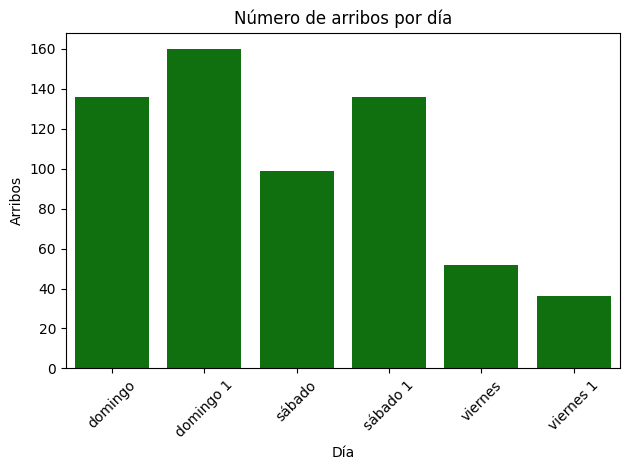

In [19]:
sns.countplot(x=df_tiempo_arribos["diaSemana"], color='green', order=sorted(df_tiempo_arribos["diaSemana"].unique()))
plt.tick_params(axis='x', rotation=45)
plt.title("Número de arribos por día")
plt.ylabel("Arribos")
plt.xlabel("Día")
plt.tight_layout()
plt.show()

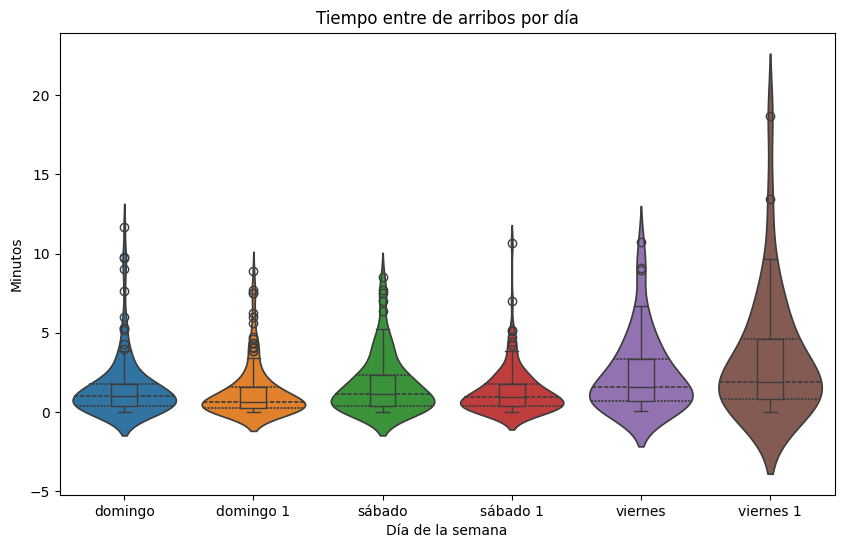

In [20]:
plt.figure(figsize=(10,6))
sns.violinplot(x="diaSemana", y="tiempo_entre_arribo", data=df_tiempo_arribos, inner="quartile",hue="diaSemana")
sns.boxplot(x="diaSemana", y="tiempo_entre_arribo", data=df_tiempo_arribos, width=0.2, hue="diaSemana")
plt.title("Tiempo entre de arribos por día")
plt.xlabel("Día de la semana")
plt.ylabel("Minutos")
plt.show()

In [21]:

def detectar_outliers(df, columnas, z_threshold=3):
    resultados_outliers = pd.DataFrame()

    for columna in columnas:
        media = df[columna].mean()
        desviacion = df[columna].std()
        
        # Calcular z-score
        df[f'z_score_{columna}'] = (df[columna] - media) / desviacion
        
        # Identificar outliers
        df[f'es_outlier_{columna}'] = df[f'z_score_{columna}'].abs() > z_threshold
        
        # Extraer solo outliers
        outliers_columna = df[df[f'es_outlier_{columna}']][[columna, f'z_score_{columna}']]
        outliers_columna['variable'] = columna
        
        # Renombrar columnas para claridad
        outliers_columna = outliers_columna.rename(columns={
            columna: 'valor',
            f'z_score_{columna}': 'z_score'
        })
        
        # Agregar al dataframe de resultados
        resultados_outliers = pd.concat([resultados_outliers, outliers_columna], ignore_index=True)
    
    return resultados_outliers

# ✅ Uso con tus columnas
columnas_a_evaluar = ['tiempo_pedido', 'tiempo_pago', 'tiempo_entre_arribo']

# Ejecutar la detección de outliers
outliers_detectados = detectar_outliers(df_tiempo_arribos, columnas_a_evaluar)

# Mostrar todos los outliers encontrados
print("\nOutliers detectados en todas las columnas:")
print(outliers_detectados)


Outliers detectados en todas las columnas:
      valor    z_score             variable
0    1.5697   4.275957        tiempo_pedido
1    1.5408   4.174749        tiempo_pedido
2    3.1238   9.718395        tiempo_pedido
3    1.2271   3.076176        tiempo_pedido
4    2.0014   5.787765        tiempo_pedido
5    1.6047   4.398526        tiempo_pedido
6    1.3670   3.566104        tiempo_pedido
7    6.1693   8.077913          tiempo_pago
8    3.6723   4.542942          tiempo_pago
9    4.3404   5.488763          tiempo_pago
10   3.5420   4.358478          tiempo_pago
11   3.1649   3.824622          tiempo_pago
12  11.3834  15.459449          tiempo_pago
13   4.9116   6.297403          tiempo_pago
14   9.7373   3.867662  tiempo_entre_arribo
15   9.8133   3.904050  tiempo_entre_arribo
16  11.6506   4.783734  tiempo_entre_arribo
17   9.0066   3.517809  tiempo_entre_arribo
18   8.9062   3.469738  tiempo_entre_arribo
19   8.5526   3.300437  tiempo_entre_arribo
20  10.6825   4.320216  tiempo_e

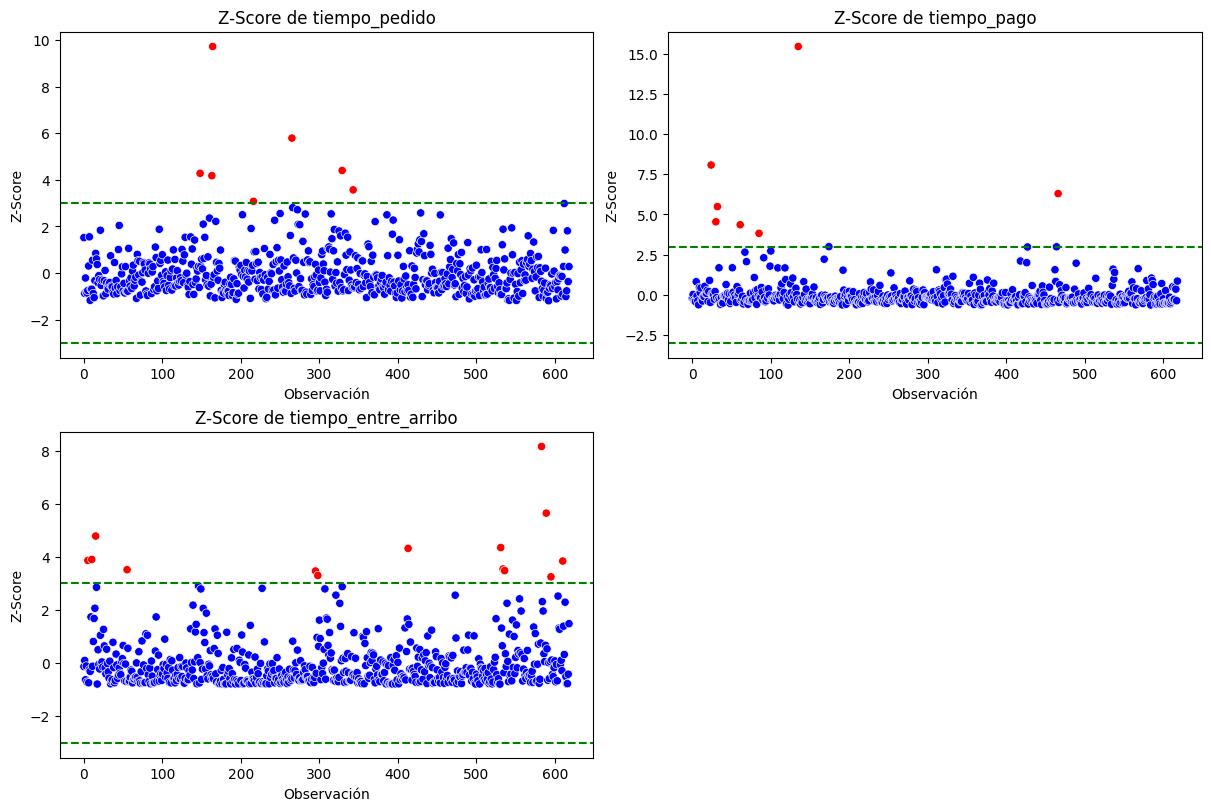

In [22]:
def plot_z_scores_outliers_grid(df, columnas, z_threshold=3):
    n_cols = 2  # Gráficas de a 2 por fila
    n_rows = math.ceil(len(columnas) / n_cols)
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows), constrained_layout=True)
    axes = axes.flatten()  # Para indexar fácil aunque sea 1D

    for i, columna in enumerate(columnas):
        z_score_col = f'z_score_{columna}'
        es_outlier_col = f'es_outlier_{columna}'
        
        sns.scatterplot(
            x=range(len(df)),
            y=df[z_score_col],
            hue=df[es_outlier_col],
            palette={True: 'red', False: 'blue'},
            ax=axes[i],
            legend=False  # Quita leyendas repetidas
        )
        
        axes[i].axhline(z_threshold, color='green', linestyle='--')
        axes[i].axhline(-z_threshold, color='green', linestyle='--')
        
        axes[i].set_title(f'Z-Score de {columna}')
        axes[i].set_xlabel('Observación')
        axes[i].set_ylabel('Z-Score')
    
    # Si sobran espacios, los ocultamos
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.show()

# Usar con tus columnas
columnas_a_evaluar = ['tiempo_pedido', 'tiempo_pago', 'tiempo_entre_arribo']
plot_z_scores_outliers_grid(df_tiempo_arribos, columnas_a_evaluar)

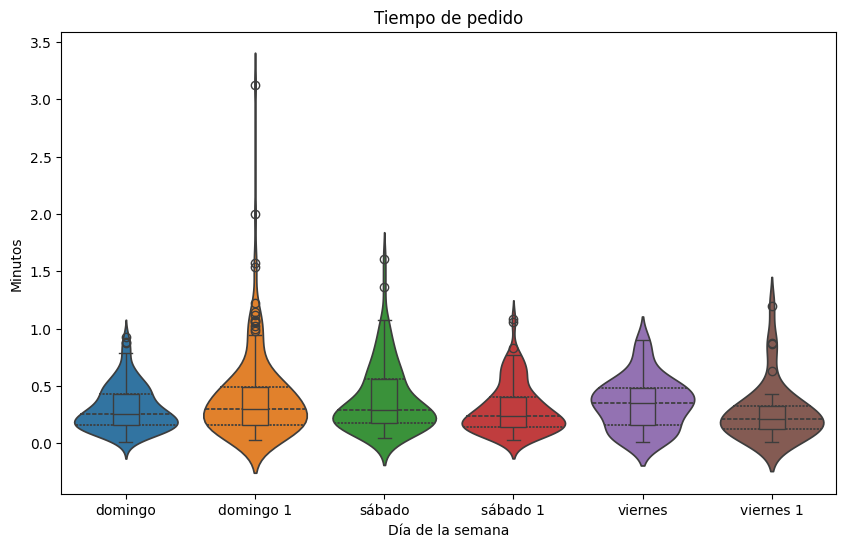

In [23]:
plt.figure(figsize=(10,6))
sns.violinplot(x="diaSemana", y="tiempo_pedido", data=df_tiempo_arribos, inner="quartile",hue="diaSemana")
sns.boxplot(x="diaSemana", y="tiempo_pedido", data=df_tiempo_arribos, width=0.2, hue="diaSemana")
plt.title("Tiempo de pedido")
plt.xlabel("Día de la semana")
plt.ylabel("Minutos")
plt.show()

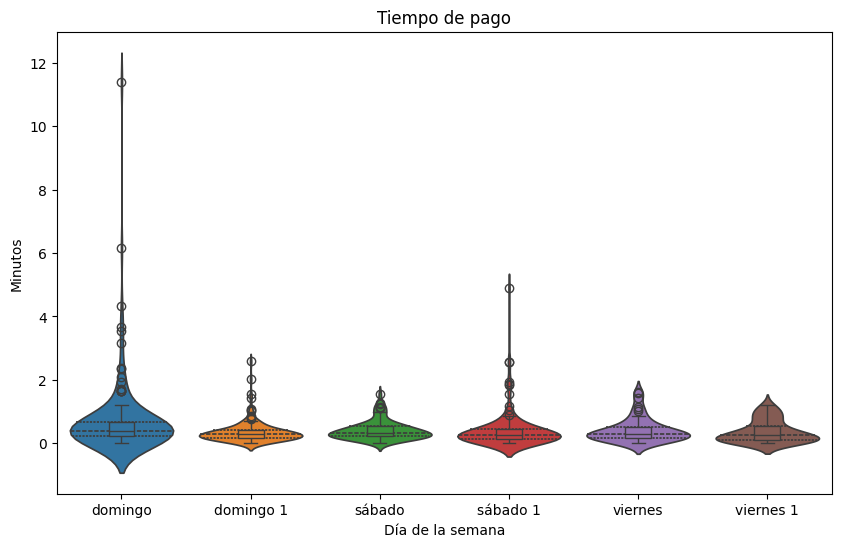

In [24]:
plt.figure(figsize=(10,6))
sns.violinplot(x="diaSemana", y="tiempo_pago", data=df_tiempo_arribos, inner="quartile",hue="diaSemana")
sns.boxplot(x="diaSemana", y="tiempo_pago", data=df_tiempo_arribos, width=0.2, hue="diaSemana")
plt.title("Tiempo de pago")
plt.xlabel("Día de la semana")
plt.ylabel("Minutos")
plt.show()

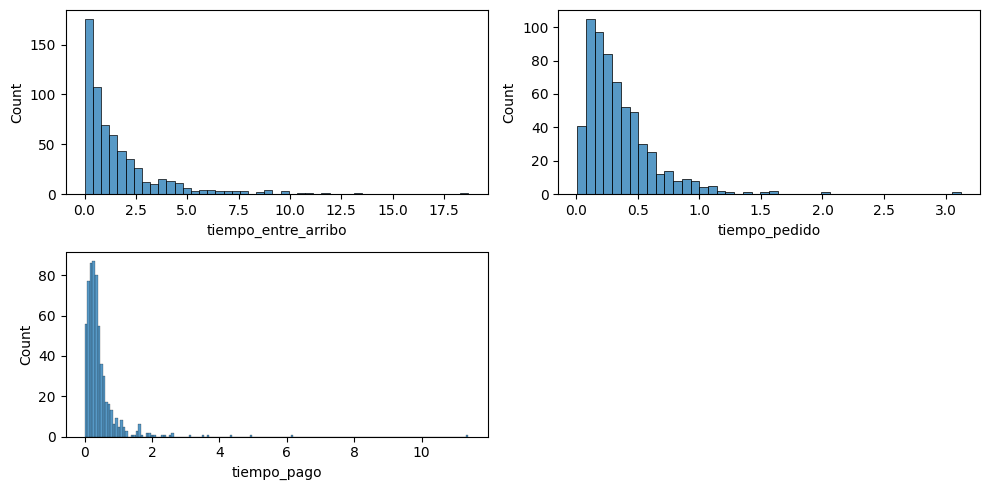

In [25]:
fig, axs = plt.subplots(2, 2, figsize=(10, 5))
sns.histplot(x='tiempo_entre_arribo', data=df_tiempo_arribos, ax=axs[0, 0])
sns.histplot(x='tiempo_pedido', data=df_tiempo_arribos, ax=axs[0, 1])
sns.histplot(x='tiempo_pago', data=df_tiempo_arribos, ax=axs[1, 0])
axs[1, 1].axis('off')
plt.tight_layout()
plt.show()

## Datos de productos

Tiempo de preparación de tipo de producto

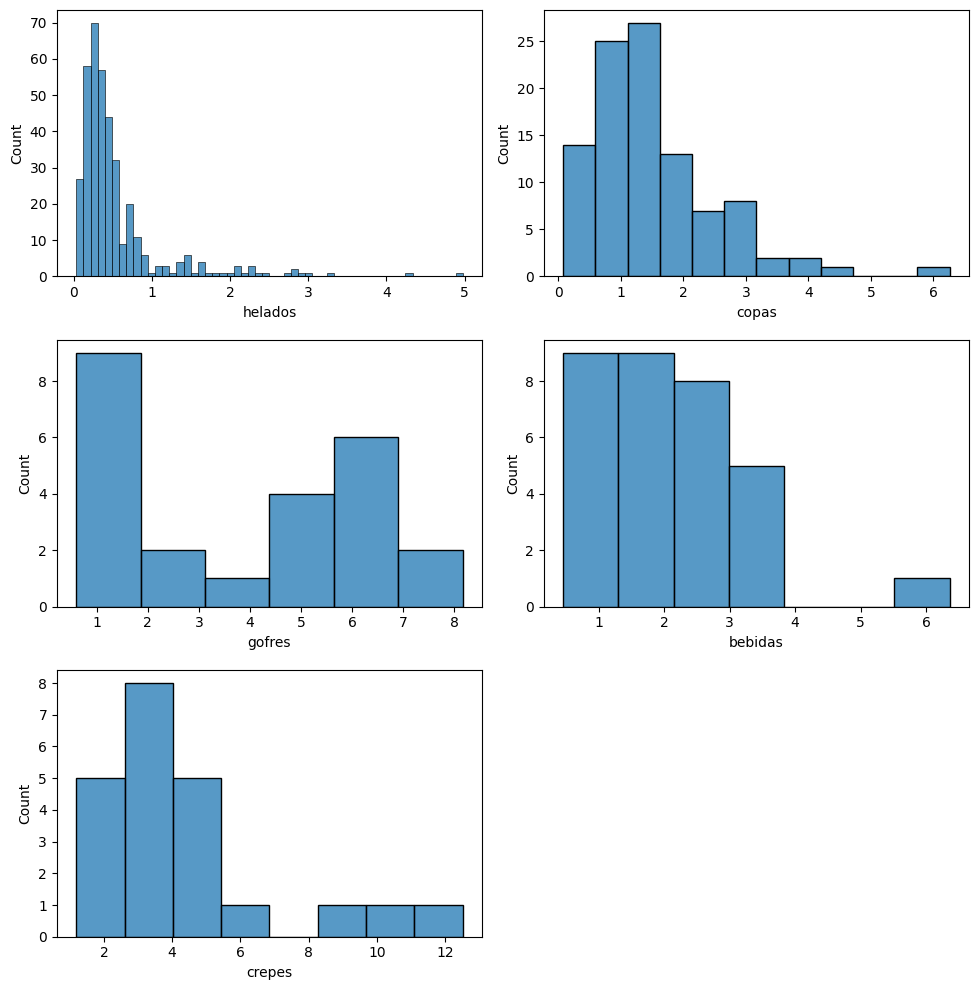

In [26]:
fig, axs = plt.subplots(3, 2, figsize=(10, 10))
sns.histplot(x='helados', data=df_tiempo_productos, ax=axs[0, 0])
sns.histplot(x='copas', data=df_tiempo_productos, ax=axs[0, 1])
sns.histplot(x='gofres', data=df_tiempo_productos, ax=axs[1, 0])
sns.histplot(x='bebidas', data=df_tiempo_productos, ax=axs[1, 1])
sns.histplot(x='crepes', data=df_tiempo_productos, ax=axs[2, 0])
plt.tight_layout()
axs[2, 1].axis('off')
plt.show()

Cantidad del tipo de producto por pedido

In [27]:
# Columnas que quieres evaluar
columnas_productos = ['helados', 'copas', 'gofres', 'bebidas', 'crepes']

# Detectar outliers con z-score
outliers_productos = detectar_outliers(df_tiempo_productos, columnas_productos)

# Verificar outliers detectados
print("\nOutliers detectados en productos:")
print(outliers_productos)


Outliers detectados en productos:
     valor   z_score variable
0   4.2727  6.091442  helados
1   2.4622  3.132266  helados
2   2.7693  3.634206  helados
3   3.2921  4.488698  helados
4   2.9675  3.958155  helados
5   4.9765  7.241770  helados
6   2.9168  3.875288  helados
7   2.8151  3.709064  helados
8   2.8030  3.689287  helados
9   6.2604  4.673141    copas
10  6.3589  3.429469  bebidas


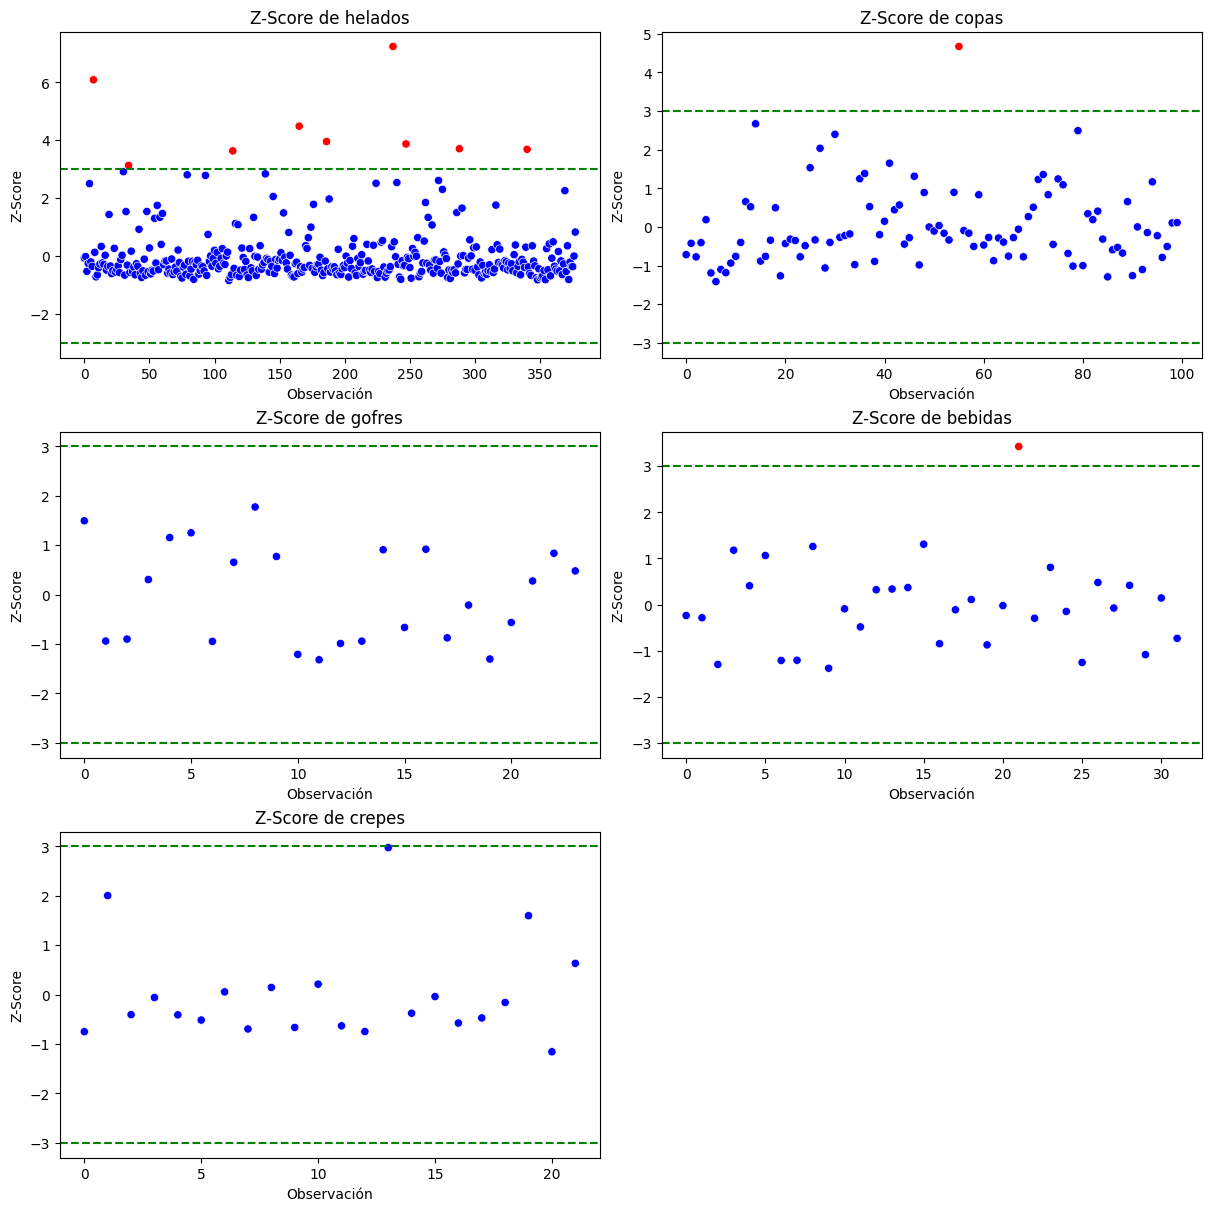

In [28]:
# Gráfico de z-scores para productos (de a 2 por fila)
plot_z_scores_outliers_grid(df_tiempo_productos, columnas_productos)
plt.show()

## Datos de mesas

<AxesSubplot: xlabel='tiempo_en_mesa', ylabel='Count'>

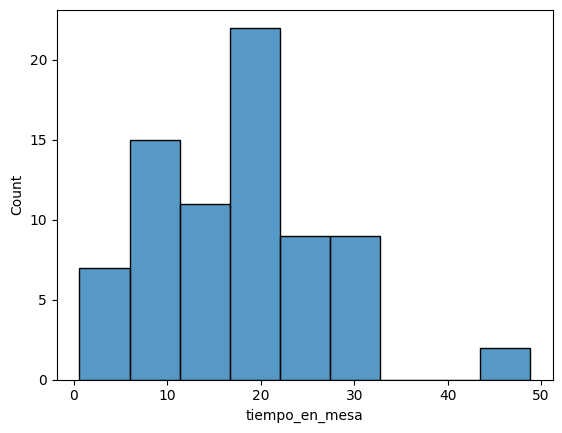

In [29]:
sns.histplot(x='tiempo_en_mesa', data=df_tiempo_mesa)

## Manejo de datos Atípicos

### Manejo del datafono

In [30]:
datafono = data_arribos[["metodoPago"]]
datafono["tiempoPago"] = df_tiempo_arribos["tiempo_pago"]
datafono["id"] = data_arribos["id"]
datafono = datafono.dropna()

In [31]:
eliminar = ["cAN06Lht5jfldendQIjb", "vCRDno3o3uVnPgLXdIxA", "sOALknG9Fzphpq0C4oen", "P48Y8LYkvy6XvKAKNZjv",
"oxdDbIutLd0TfIPg9a9X", "NSlYPqtI4YCAimtHWbe6", "Y1B3gnc63CzspQ2xLv2v", "cTN3SsFbjxv1A399sgZ5", "wtgjMi4swUQqU7SOongK",
"bb4QT91VrWwtdFnnGC3N", "96MjEGaBxjclHeSFMd5D", "AeAbJrIZ5oNtKkTwFip5", "xY207pe3c0xJlGdV3CZ5", "foo3ozUDgAxCbdwLvjK7",
"0zgCGZK0nPUupXciwqBw"]
df_tarjeta = datafono[datafono["metodoPago"].str.lower() == "tarjeta"]
df_tarjeta = df_tarjeta[~df_tarjeta["id"].isin(eliminar)]
median_value = np.median(df_tarjeta["tiempoPago"])

In [32]:
mask = data_arribos["id"].isin(eliminar)

df_tiempo_arribos.loc[mask, "tiempo_pago"] = median_value

In [33]:

df_tiempo_arribos = df_tiempo_arribos.reset_index(drop=True)
datafono = datafono.reset_index(drop=True)

df_tiempo_arribos["metodoPago"] = datafono["metodoPago"].values
df_tiempo_arribos = df_tiempo_arribos[~df_tiempo_arribos["metodoPago"].str.contains("digital", na=False, regex=True)]

### Manejo de tiempos de arribo 

In [34]:
columns_to_fix = ["tiempo_entre_arribo", "tiempo_pedido", "tiempo_pago"]

for col in columns_to_fix:
    if col == "tiempo_pago":
        for metodo in df_tiempo_arribos["metodoPago"].unique():
            idx = df_tiempo_arribos["metodoPago"] == metodo

            if metodo.lower() == "tarjeta":
                # Dividir en dos subconjuntos según el valor
                idx_menor = idx & (df_tiempo_arribos[col] < 1.2)
                idx_mayor = idx & (df_tiempo_arribos[col] >= 1.2)

                for subset_idx in [idx_menor, idx_mayor]:
                    Q1 = df_tiempo_arribos.loc[subset_idx, col].quantile(0.25)
                    Q3 = df_tiempo_arribos.loc[subset_idx, col].quantile(0.75)
                    IQR = Q3 - Q1
                    lower_bound = Q1 - 1.5 * IQR
                    upper_bound = Q3 + 1.5 * IQR
                    median_val = df_tiempo_arribos.loc[subset_idx, col].median()

                    df_tiempo_arribos.loc[subset_idx & (df_tiempo_arribos[col] < lower_bound), col] = median_val
                    df_tiempo_arribos.loc[subset_idx & (df_tiempo_arribos[col] > upper_bound), col] = median_val
            else:
                Q1 = df_tiempo_arribos.loc[idx, col].quantile(0.25)
                Q3 = df_tiempo_arribos.loc[idx, col].quantile(0.75)
                IQR = Q3 - Q1
                lower_bound = Q1 - 1.5 * IQR
                upper_bound = Q3 + 1.5 * IQR
                median_val = df_tiempo_arribos.loc[idx, col].median()

                df_tiempo_arribos.loc[idx & (df_tiempo_arribos[col] < lower_bound), col] = median_val
                df_tiempo_arribos.loc[idx & (df_tiempo_arribos[col] > upper_bound), col] = median_val
    else:
        # Tratamiento sin distinguir método de pago
        Q1 = df_tiempo_arribos[col].quantile(0.25)
        Q3 = df_tiempo_arribos[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        median_val = df_tiempo_arribos[col].median()

        df_tiempo_arribos.loc[df_tiempo_arribos[col] < lower_bound, col] = median_val
        df_tiempo_arribos.loc[df_tiempo_arribos[col] > upper_bound, col] = median_val


### Manejo de tiempo de productos

In [35]:
df_tiempo_productos["gofresme"] = df_tiempo_productos["gofres"][df_tiempo_productos["gofres"]<= 4]
df_tiempo_productos["gofresma"] = df_tiempo_productos["gofres"][df_tiempo_productos["gofres"]> 4]
producto = ["helados", "bebidas", "copas", "crepes","gofresme","gofresma"]

for i in producto:
    if i == "helados":

        df_tiempo_productos["artesano"] = df_tiempo_productos[i][df_tiempo_productos[i] >= 1]

        # Reemplazar esos valores por NaN
        df_tiempo_productos[i] = df_tiempo_productos[i].apply(
            lambda x: np.nan if x >= 1 else x
        )

        # Calcular la mediana sin NaNs
        median_val = df_tiempo_productos[i].median()

        # Calcular outliers con IQR
        Q1 = df_tiempo_productos[i].quantile(0.25)
        Q3 = df_tiempo_productos[i].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        df_tiempo_productos[i] = df_tiempo_productos[i].apply(
            lambda x: median_val if not pd.isna(x) and (x < lower_bound or x > upper_bound) else x
        )


    else:
        # Para los demás productos
        Q1 = df_tiempo_productos[i].quantile(0.25)
        Q3 = df_tiempo_productos[i].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        median_val = df_tiempo_productos[i].median()

        df_tiempo_productos[i] = df_tiempo_productos[i].apply(
            lambda x: median_val if x < lower_bound or x > upper_bound else x
        )



# Visualización de datos limpios

## Distribución de tiempo entre arribo

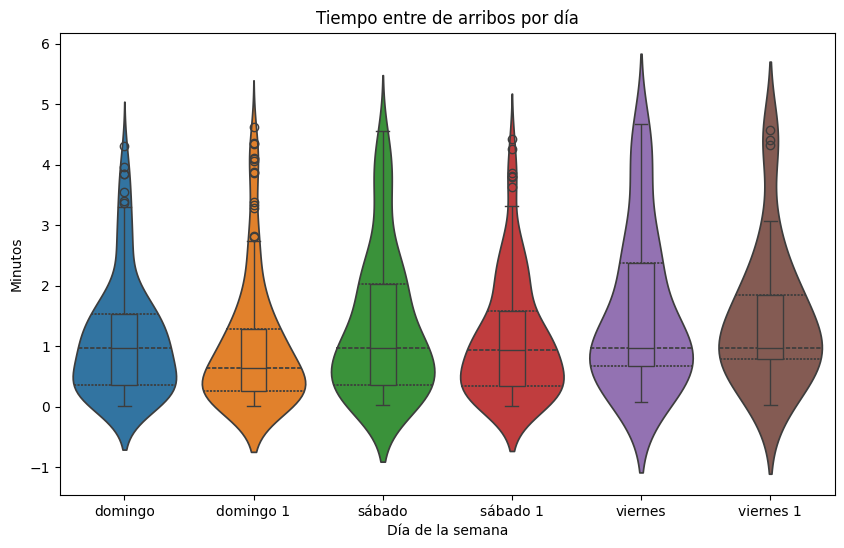

In [36]:
plt.figure(figsize=(10,6))
sns.violinplot(x="diaSemana", y="tiempo_entre_arribo", data=df_tiempo_arribos, inner="quartile",hue="diaSemana")
sns.boxplot(x="diaSemana", y="tiempo_entre_arribo", data=df_tiempo_arribos, width=0.2, hue="diaSemana")
plt.title("Tiempo entre de arribos por día")
plt.xlabel("Día de la semana")
plt.ylabel("Minutos")
plt.show()

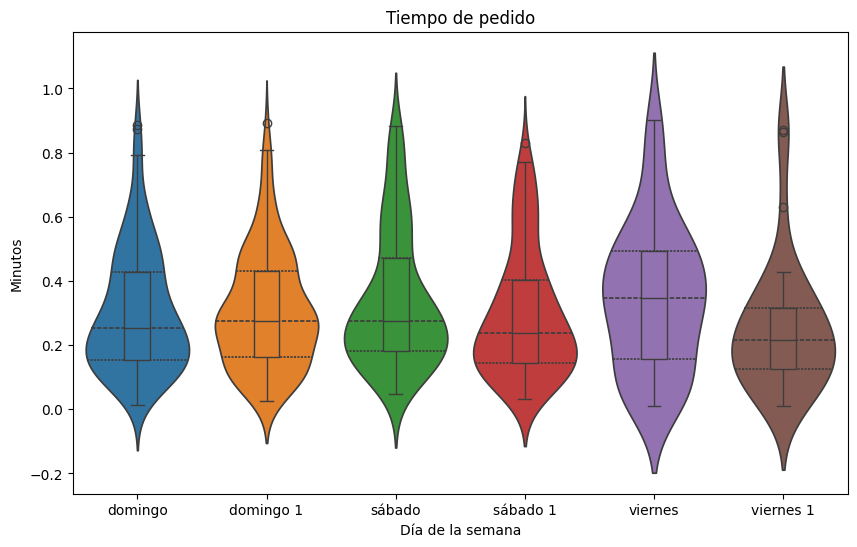

In [37]:
plt.figure(figsize=(10,6))
sns.violinplot(x="diaSemana", y="tiempo_pedido", data=df_tiempo_arribos, inner="quartile",hue="diaSemana")
sns.boxplot(x="diaSemana", y="tiempo_pedido", data=df_tiempo_arribos, width=0.2, hue="diaSemana")
plt.title("Tiempo de pedido")
plt.xlabel("Día de la semana")
plt.ylabel("Minutos")
plt.show()

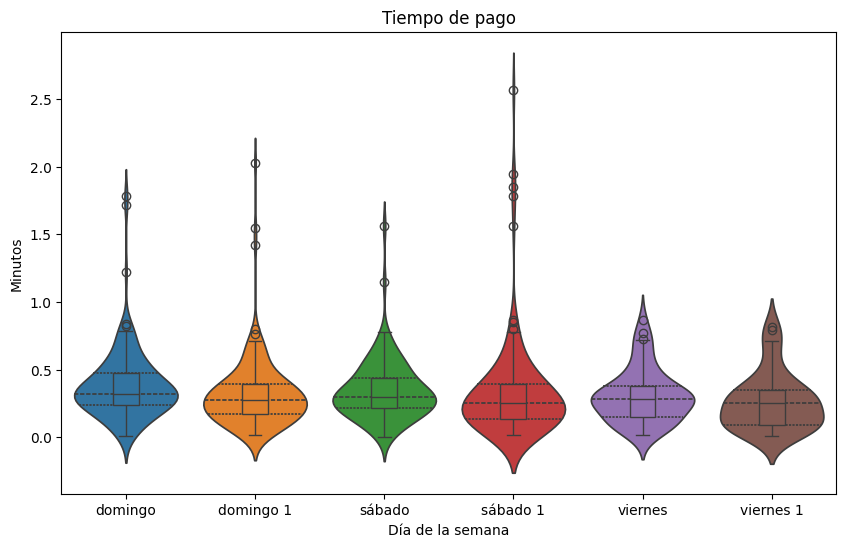

In [38]:
plt.figure(figsize=(10,6))
sns.violinplot(x="diaSemana", y="tiempo_pago", data=df_tiempo_arribos, inner="quartile",hue="diaSemana")
sns.boxplot(x="diaSemana", y="tiempo_pago", data=df_tiempo_arribos, width=0.2, hue="diaSemana")
plt.title("Tiempo de pago")
plt.xlabel("Día de la semana")
plt.ylabel("Minutos")
plt.show()

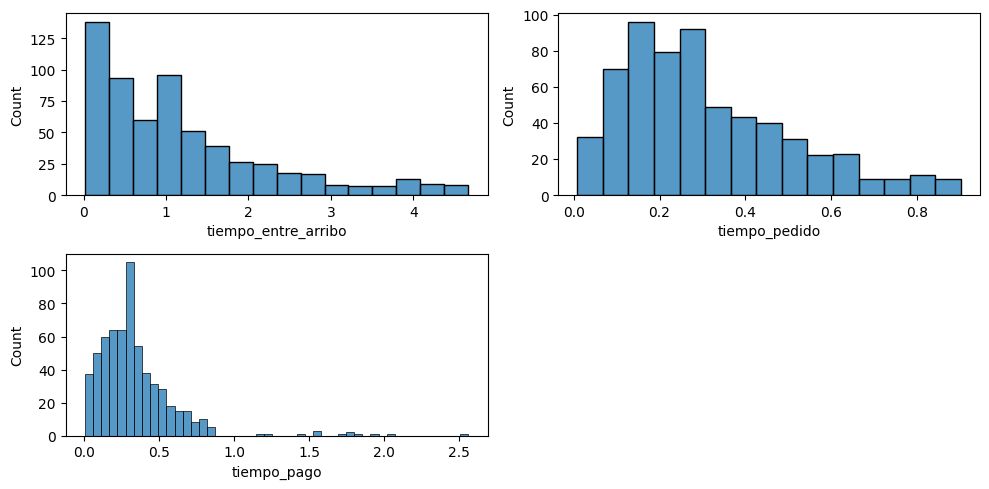

In [39]:
fig, axs = plt.subplots(2, 2, figsize=(10, 5))
sns.histplot(x='tiempo_entre_arribo', data=df_tiempo_arribos, ax=axs[0, 0])
sns.histplot(x='tiempo_pedido', data=df_tiempo_arribos, ax=axs[0, 1])
sns.histplot(x='tiempo_pago', data=df_tiempo_arribos, ax=axs[1, 0])
axs[1, 1].axis('off')
plt.tight_layout()
plt.show()

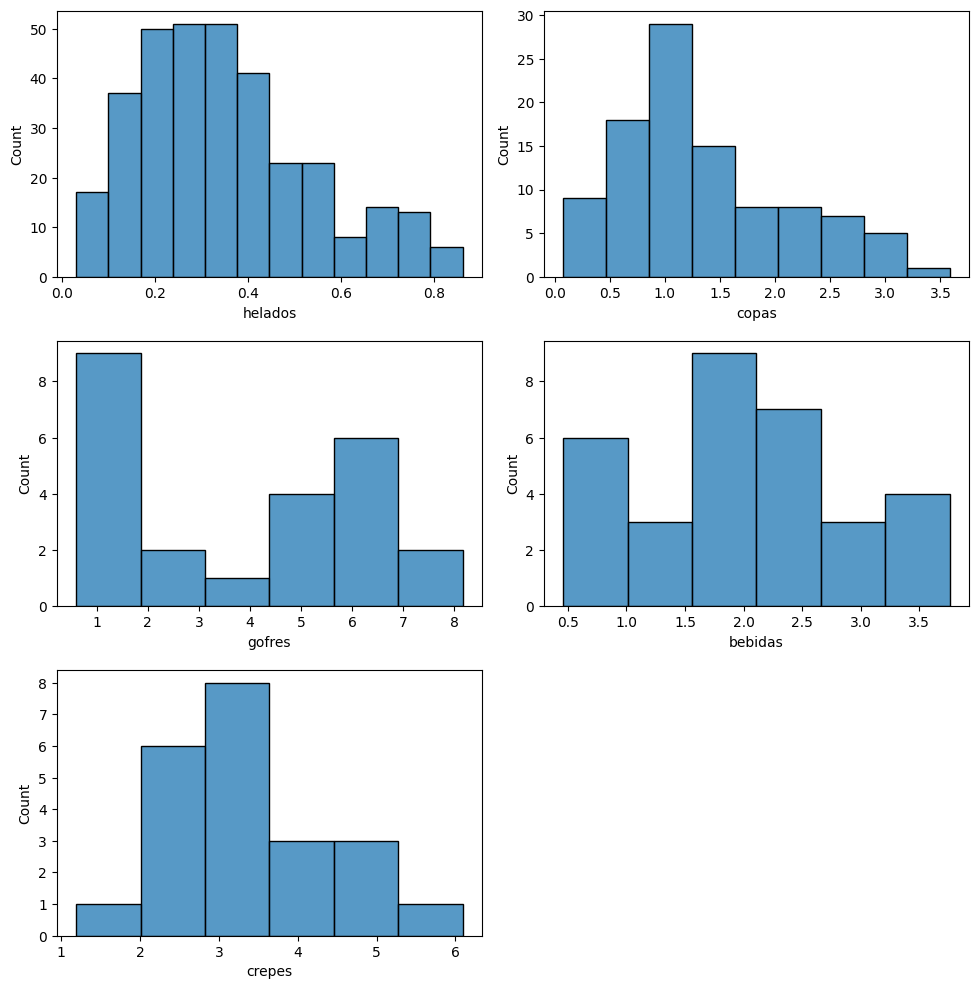

In [40]:
fig, axs = plt.subplots(3, 2, figsize=(10, 10))
sns.histplot(x='helados', data=df_tiempo_productos, ax=axs[0, 0])
sns.histplot(x='copas', data=df_tiempo_productos, ax=axs[0, 1])
sns.histplot(x='gofres', data=df_tiempo_productos, ax=axs[1, 0])
sns.histplot(x='bebidas', data=df_tiempo_productos, ax=axs[1, 1])
sns.histplot(x='crepes', data=df_tiempo_productos, ax=axs[2, 0])
plt.tight_layout()
axs[2, 1].axis('off')
plt.show()

<AxesSubplot: xlabel='tiempo_en_mesa', ylabel='Count'>

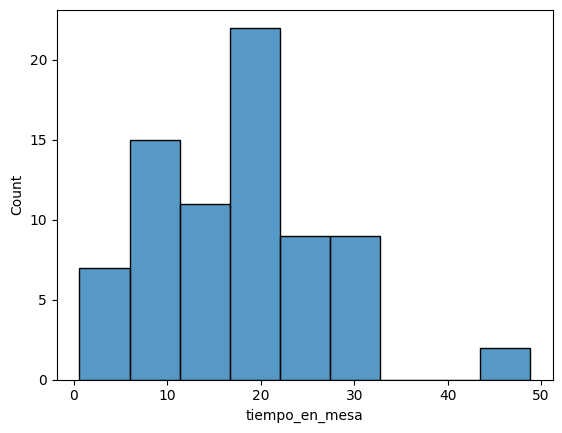

In [41]:
sns.histplot(x='tiempo_en_mesa', data=df_tiempo_mesa)

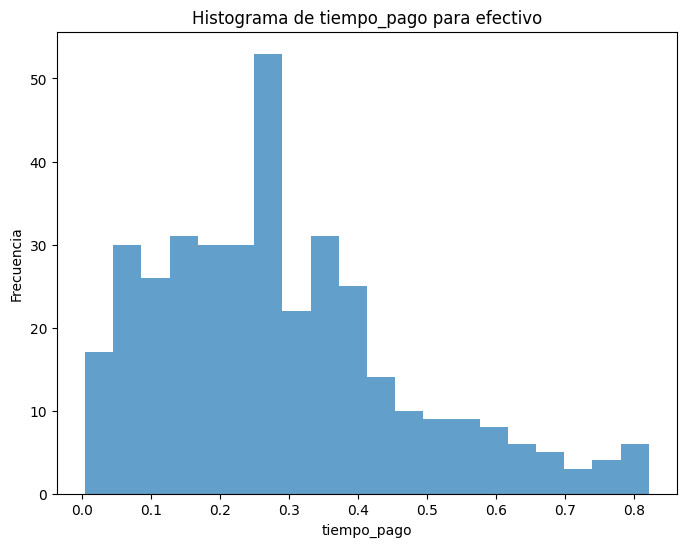

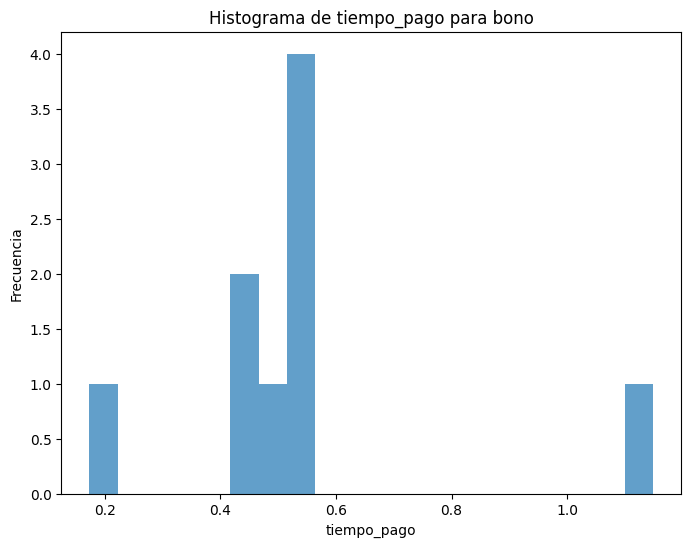

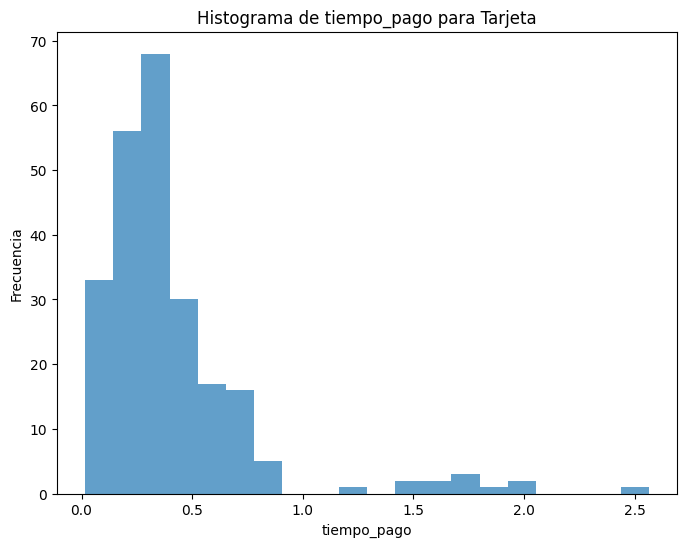

In [42]:
import matplotlib.pyplot as plt

time_columns = ["tiempo_pago"]
payment_methods = df_tiempo_arribos["metodoPago"].unique()

# Iteramos por cada columna de tiempo
for col in time_columns:
    # Iteramos por cada método de pago
    for metodo in payment_methods:
        plt.figure(figsize=(8, 6))
        subset = df_tiempo_arribos[df_tiempo_arribos["metodoPago"] == metodo]
        plt.hist(subset[col], bins=20, alpha=0.7)
        plt.xlabel(col)
        plt.ylabel("Frecuencia")
        plt.title(f"Histograma de {col} para {metodo}")
        plt.show()




## Prueba de Independencia

In [43]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.stats.diagnostic import acorr_ljungbox

def graficar_independencia_multiple(df, columnas, max_lags=20, titulo="ACF - Prueba de Independencia"):
    n_cols = 2
    n_rows = (len(columnas) + n_cols - 1) // n_cols  # Redondea hacia arriba

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(12, 3 * n_rows))
    axs = axs.flatten()

    print(f"\n=== {titulo} ===")

    for idx, col in enumerate(columnas):
        serie = df[col].dropna()

        # Validar datos
        if serie.std() == 0 or len(serie) < 5:
            print(f" {col}: No se puede calcular (varianza cero o pocos datos)")
            axs[idx].axis('off')
            axs[idx].set_title(f'{col}: Sin Datos Válidos')
            continue

        # Ajustar lags
        lags = min(max_lags, len(serie)//2)

        # Ljung-Box
        lb_test = acorr_ljungbox(serie, lags=[lags], return_df=True)
        p_valor = lb_test['lb_pvalue'].values[0]
        print(f"{col} ➔ Ljung-Box (lag {lags}): p-valor = {p_valor:.3f}")

        # Plot ACF
        sm.graphics.tsa.plot_acf(serie, lags=lags, ax=axs[idx], zero=False)
        axs[idx].set_title(f'{col} (p={p_valor:.3f})')

    # Apagar ejes vacíos si sobran
    for i in range(len(columnas), len(axs)):
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()



=== Independencia - df_tiempo_arribos ===
tiempo_entre_arribo ➔ Ljung-Box (lag 20): p-valor = 0.598
tiempo_pedido ➔ Ljung-Box (lag 20): p-valor = 0.144
tiempo_pago ➔ Ljung-Box (lag 20): p-valor = 0.711


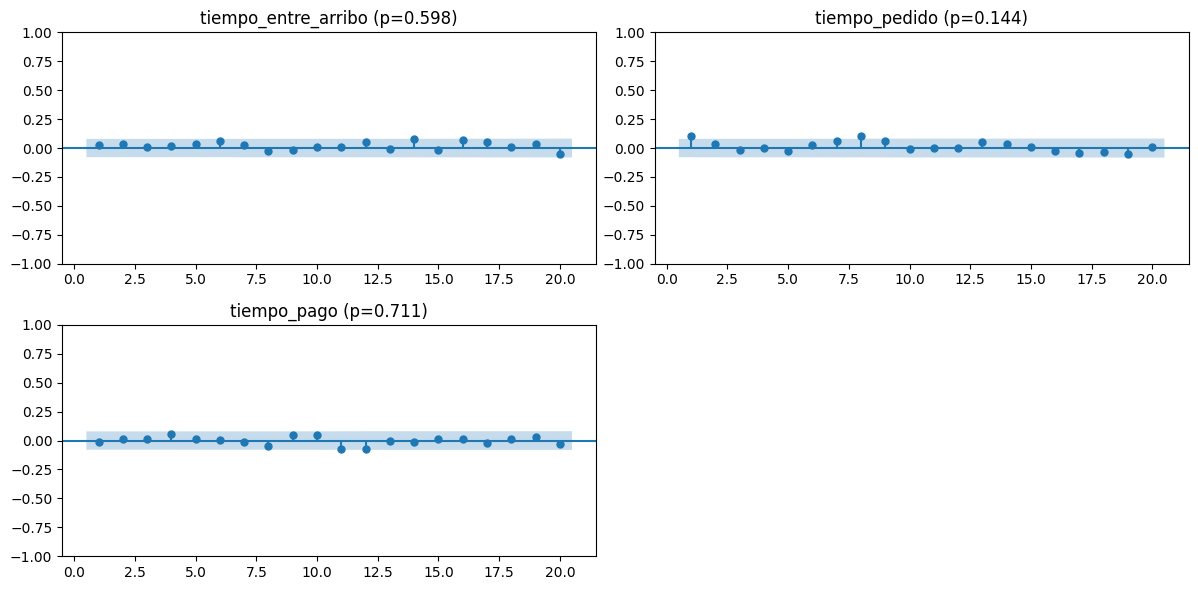

In [44]:
columnas_df1 = ['tiempo_entre_arribo', 'tiempo_pedido', 'tiempo_pago']
graficar_independencia_multiple(df_tiempo_arribos, columnas_df1, max_lags=20, titulo="Independencia - df_tiempo_arribos")


=== Independencia - df_tiempo_productos ===
helados ➔ Ljung-Box (lag 20): p-valor = 0.769
copas ➔ Ljung-Box (lag 20): p-valor = 0.564
gofres ➔ Ljung-Box (lag 12): p-valor = 0.512
bebidas ➔ Ljung-Box (lag 16): p-valor = 0.720
crepes ➔ Ljung-Box (lag 11): p-valor = 0.246


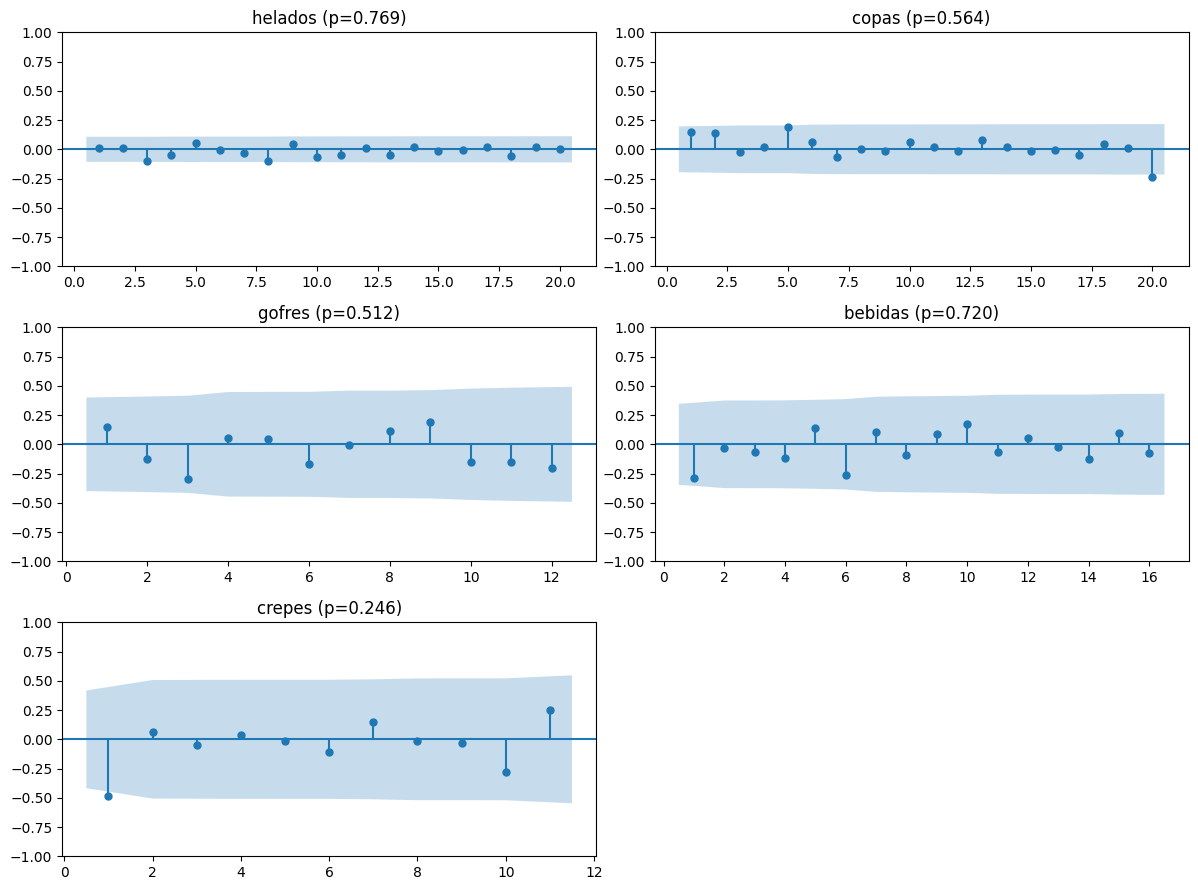

In [45]:
columnas_df2 = ['helados', 'copas', 'gofres', 'bebidas', 'crepes']
graficar_independencia_multiple(df_tiempo_productos, columnas_df2, max_lags=20, titulo="Independencia - df_tiempo_productos")

## Pruebas de Estacionariedad

## Tiempo entre arribos
Se busca ver que si el tiempo entre arribos varía según el día de la semana que se tomaron los datos.

In [46]:
print("Prueba ANOVA para tiempo entre arribos")
modelo = ols('tiempo_entre_arribo ~ C(diaSemana)', data=df_tiempo_arribos).fit()
anova_table = sm.stats.anova_lm(modelo, typ=2)
print("ANOVA:")
print(anova_table)


Prueba ANOVA para tiempo entre arribos
ANOVA:
                  sum_sq     df         F    PR(>F)
C(diaSemana)   18.222504    5.0  3.192488  0.007453
Residual      695.226099  609.0       NaN       NaN


In [47]:
# Prueba de Tukey el ANOVA es significativo
print("\nTukey HSD para tiempo entre arrivos por día:")
tukey = pairwise_tukeyhsd(endog=df_tiempo_arribos['tiempo_entre_arribo'],
                          groups=df_tiempo_arribos['diaSemana'],
                          alpha=0.05)
print(tukey)


Tukey HSD para tiempo entre arrivos por día:
   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
  group1    group2  meandiff p-adj   lower  upper  reject
---------------------------------------------------------
  domingo domingo 1  -0.1214 0.9271 -0.4791 0.2362  False
  domingo    sábado   0.1951 0.7406 -0.2097 0.5999  False
  domingo  sábado 1  -0.0115    1.0 -0.3833 0.3603  False
  domingo   viernes   0.4318 0.1447 -0.0744  0.938  False
  domingo viernes 1    0.353 0.4926 -0.2204 0.9264  False
domingo 1    sábado   0.3165 0.1889 -0.0741 0.7071  False
domingo 1  sábado 1     0.11 0.9506 -0.2463 0.4662  False
domingo 1   viernes   0.5532 0.0183  0.0583 1.0481   True
domingo 1 viernes 1   0.4744 0.1553  -0.089 1.0379  False
   sábado  sábado 1  -0.2065 0.6879 -0.6101  0.197  False
   sábado   viernes   0.2367 0.7976 -0.2932 0.7667  False
   sábado viernes 1   0.1579 0.9741 -0.4365 0.7524  False
 sábado 1   viernes   0.4432 0.1232 -0.0619 0.9484  False
 sábado 1 viernes 1   0.36

Como se puede ver en la tabla anterior en la prueba de anova el valor p es menor a 0.05 por lo que se rechaza la hipótesis nula lo que significa que si hay una diferencia significativa en las medias del tiempo entre arribos según el día de la semana. Al realizar la prueba de Tuckey se puede ver que la diferencia está en las comparaciones entre viernes con sábados y viernes con con domingo. Esto quiere decir que el tiempo etre arrivos del domigo y sábado es estacionario sin emabrgo el viernes no por lo que habría que realizar una distribución para el fin de semana y otra distinta para el viernes. Por eso se realiza la división de los datos por el día.

In [48]:

# DataFrame para el fin de semana (sábado y domingo, con o sin " 1")
df_weekend = df_tiempo_arribos[
    df_tiempo_arribos["diaSemana"].str.contains(r'(?i)(sábado|sábado 1|domingo|domingo 1)', na=False)
]

# DataFrame para viernes (viernes y viernes 1)
df_friday = df_tiempo_arribos[
    df_tiempo_arribos["diaSemana"].str.contains(r'(?i)(viernes|viernes 1)', na=False)
]


## Tiempo pedido
Se busca ver que si el tiempo de pedido varía según el día de la semana que se tomaron los datos.

In [49]:
print("Prueba ANOVA para tiempo de pedido")
modelo1 = ols('tiempo_pedido ~ C(diaSemana)', data=df_tiempo_arribos).fit()
anova_table1 = sm.stats.anova_lm(modelo1, typ=2)
print("ANOVA:")
print(anova_table1)

Prueba ANOVA para tiempo de pedido
ANOVA:
                 sum_sq     df         F    PR(>F)
C(diaSemana)   0.300433    5.0  1.566726  0.167443
Residual      23.356223  609.0       NaN       NaN


In [50]:
# Prueba de Tukey el ANOVA es significativo
print("\nTukey HSD para tiempo de pedidos por día:")
tukey = pairwise_tukeyhsd(endog=df_tiempo_arribos['tiempo_pedido'],
                          groups=df_tiempo_arribos['diaSemana'],
                          alpha=0.05)
print(tukey)


Tukey HSD para tiempo de pedidos por día:
   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
  group1    group2  meandiff p-adj   lower  upper  reject
---------------------------------------------------------
  domingo domingo 1   0.0051 0.9999 -0.0604 0.0707  False
  domingo    sábado   0.0344 0.7701 -0.0398 0.1086  False
  domingo  sábado 1  -0.0085 0.9992 -0.0767 0.0596  False
  domingo   viernes   0.0438 0.7568  -0.049 0.1366  False
  domingo viernes 1  -0.0506 0.7408 -0.1557 0.0545  False
domingo 1    sábado   0.0293 0.8511 -0.0423 0.1009  False
domingo 1  sábado 1  -0.0136 0.9912 -0.0789 0.0516  False
domingo 1   viernes   0.0387 0.8277  -0.052 0.1294  False
domingo 1 viernes 1  -0.0558  0.636  -0.159 0.0475  False
   sábado  sábado 1  -0.0429 0.5591 -0.1169  0.031  False
   sábado   viernes   0.0094 0.9998 -0.0878 0.1065  False
   sábado viernes 1  -0.0851 0.2247  -0.194 0.0239  False
 sábado 1   viernes   0.0523 0.5886 -0.0403 0.1449  False
 sábado 1 viernes 1  -0.0421 

## Tiempo Pago
Se busca ver que si el tiempo de pago varía según el día de la semana que se tomaron los datos.

In [51]:
dfs_by_payment = {}

# Obtener los métodos de pago únicos
unique_payment_methods = df_tiempo_arribos["metodoPago"].unique()

# Iterar y crear un DataFrame para cada método de pago
for metodo in unique_payment_methods:
    dfs_by_payment[metodo] = df_tiempo_arribos[df_tiempo_arribos["metodoPago"] == metodo]

for i in dfs_by_payment:
    print(f"Prueba ANOVA para tiempo de pago por {i}")
    modelo2 = ols('tiempo_pago ~ C(diaSemana)', data=dfs_by_payment[i]).fit()
    anova_table2 = sm.stats.anova_lm(modelo2, typ=2)
    print("ANOVA:")
    print(anova_table2)
    print("-----------------")

Prueba ANOVA para tiempo de pago por efectivo
ANOVA:
                 sum_sq     df         F    PR(>F)
C(diaSemana)   0.356466    5.0  2.231702  0.050677
Residual      11.596277  363.0       NaN       NaN
-----------------
Prueba ANOVA para tiempo de pago por bono
ANOVA:
                sum_sq   df         F   PR(>F)
C(diaSemana)  0.018230  3.0  0.058463  0.97946
Residual      0.519684  5.0       NaN      NaN
-----------------
Prueba ANOVA para tiempo de pago por Tarjeta
ANOVA:
                 sum_sq     df         F   PR(>F)
C(diaSemana)   0.377534    5.0  0.546877  0.74062
Residual      31.893938  231.0       NaN      NaN
-----------------


In [52]:
# Prueba de Tukey el ANOVA es significativo
print("\nTukey HSD para tiempo de pago por método de pago:")
tukey2 = pairwise_tukeyhsd(endog=df_tiempo_arribos['tiempo_pago'],
                          groups=df_tiempo_arribos['metodoPago'],
                          alpha=0.05)
print(tukey2)


Tukey HSD para tiempo de pago por método de pago:
  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1  group2  meandiff p-adj   lower   upper  reject
-------------------------------------------------------
Tarjeta     bono   0.1188 0.3991 -0.0969  0.3346  False
Tarjeta efectivo  -0.1198    0.0 -0.1727 -0.0669   True
   bono efectivo  -0.2387 0.0247  -0.453 -0.0243   True
-------------------------------------------------------


In [53]:
df_efectivo = dfs_by_payment["efectivo"][["tiempo_pago"]].rename(columns={"tiempo_pago": "efectivo"})
df_bono     = dfs_by_payment["bono"][["tiempo_pago"]].rename(columns={"tiempo_pago": "bono"})
tarjetame = dfs_by_payment["Tarjeta"][dfs_by_payment["Tarjeta"]["tiempo_pago"] < 1.2]["tiempo_pago"].reset_index(drop=True)
tarjetama = dfs_by_payment["Tarjeta"][dfs_by_payment["Tarjeta"]["tiempo_pago"] >= 1.2]["tiempo_pago"].reset_index(drop=True)

df_tarjeta = pd.DataFrame({
    "tarjetame": tarjetame,
    "tarjetama": tarjetama
})

## Tiempo Mesas
Se busca ver que si el tiempo de permanencia de las personas en una mesa varía según el día de la semana que se tomaron los datos.

In [54]:
print("Prueba ANOVA para tiempo de mesas")
modelo3 = ols('tiempo_en_mesa ~ C(diaSemana)', data=df_tiempo_mesa).fit()
anova_table3 = sm.stats.anova_lm(modelo3, typ=2)
print("ANOVA:")
print(anova_table3)

Prueba ANOVA para tiempo de mesas
ANOVA:
                   sum_sq    df         F    PR(>F)
C(diaSemana)   577.812761   3.0  2.190972  0.096617
Residual      6241.478455  71.0       NaN       NaN


En el caso de las mesas el valor p es mayor a 0.05 por lo que no se rechaza la hipótesis nula, lo que quiere decir que no se presenta diferencia significativa entre los días. Esto quiere decir que se toma la misma distribución de tiempos en mesa para la simulación de viernes, sábado y domingo.

# Pruebas de Bondad de Ajuste y Asignación de la distribución

Se realiza la prueba de varias de las distribuciones para ver cual se ajusta mejor a los datos. En este caso en las gráficas a simple vista no se vio que alguna fuera bimodal por lo que primero se realiza

### Ajuste Distribuciones Continuas (Tiempos)

In [55]:
from scipy.stats import kstest, norm, gamma, beta, lognorm, expon, triang, uniform, weibull_min
candidate_distributions = {
    'normal': {
        'fit': lambda d: norm.fit(d),
        'cdf': lambda x, params: norm.cdf(x, loc=params[0], scale=params[1])
    },
    'gamma': {
        'fit': lambda d: gamma.fit(d),
        'cdf': lambda x, params: gamma.cdf(x, a=params[0], loc=params[1], scale=params[2])
    },
    'beta': {
        'fit': lambda d: beta.fit(d),
        'cdf': lambda x, params: beta.cdf(x, a=params[0], b=params[1], loc=params[2], scale=params[3])
    },
    'lognormal': {
        'fit': lambda d: lognorm.fit(d, floc=0),
        'cdf': lambda x, params: lognorm.cdf(x, s=params[0], loc=params[1], scale=params[2])
    },
    'exponential': {
        'fit': lambda d: expon.fit(d),
        'cdf': lambda x, params: expon.cdf(x, loc=params[0], scale=params[1])
    },
    'triangular': {
        'fit': lambda d: triang.fit(d),
        'cdf': lambda x, params: triang.cdf(x, c=params[0], loc=params[1], scale=params[2])
    },
    'uniform': {
        'fit': lambda d: uniform.fit(d),
        'cdf': lambda x, params: uniform.cdf(x, loc=params[0], scale=params[1])
    },
    'weibull': {
        'fit': lambda d: weibull_min.fit(d),
        'cdf': lambda x, params: weibull_min.cdf(x, c=params[0], loc=params[1], scale=params[2])
    }
}


In [56]:
import numpy as np
from scipy.stats import norm, gamma, beta, lognorm, expon, triang, uniform, weibull_min, kstest

# Lista de columnas por DataFrame
columnas_df_tiempo_arribos = ['tiempo_pedido']
columnas_df_efectivo = ['efectivo']
columnas_df_tarjeta = ['tarjetame', 'tarjetama']
columnas_df_bono= ['bono']
columnas_df_friday = ["tiempo_entre_arribo"]
columnas_df_weekend = ["tiempo_entre_arribo"]
columnas_df_tiempo_productos = ['helados', 'copas', 'gofresme', 'gofresma', 'bebidas', 'crepes', 'artesano']
columnas_df_tiempo_mesa = ['tiempo_en_mesa']

# Unión de DataFrames y columnas
df_dict = {
    'df_tiempo_arribos': df_tiempo_arribos,
    'df_friday': df_friday,
    'df_weekend': df_weekend,
    'df_tiempo_productos': df_tiempo_productos,
    'df_tiempo_mesa': df_tiempo_mesa,
    'df_efectivo': df_efectivo,
    'df_tarjeta': df_tarjeta,
    'df_bono': df_bono
}

# Evaluar distribuciones para cada columna
for df_name, columnas in zip(df_dict.keys(), [columnas_df_tiempo_arribos, columnas_df_friday, columnas_df_weekend, columnas_df_tiempo_productos, columnas_df_tiempo_mesa, columnas_df_efectivo, columnas_df_tarjeta, columnas_df_bono]):
    df = df_dict[df_name]
    for col in columnas:
        data_col = df[col].dropna().values
        print(f"\n=== Evaluando columna '{col}' del DataFrame '{df_name}' ===")
        fit_results = {}
        for name, funcs in candidate_distributions.items():
            try:
                params = funcs['fit'](data_col)
                rounded_params = tuple(np.round(params, 4))  # Redondear a 4 decimales
                d_stat, p_val = kstest(data_col, lambda x: funcs['cdf'](x, params))
                fit_results[name] = {'params': rounded_params, 'ks_stat': d_stat, 'p_value': p_val}
                print(f"  {name.capitalize():10s} | KS = {d_stat:.4f} | p-valor = {p_val:.4f} | Parámetros: {rounded_params}")
            except Exception as e:
                print(f"  {name.capitalize():10s} | Error en el ajuste: {e}")
                fit_results[name] = {'params': None, 'ks_stat': None, 'p_value': 0}
        best_candidate = max(fit_results.items(), key=lambda x: x[1]['p_value'])
        print(f"  -> Mejor ajuste: {best_candidate[0].capitalize()} con p-valor = {best_candidate[1]['p_value']:.4f}")
        print(f"     Parámetros del mejor ajuste: {best_candidate[1]['params']}")




=== Evaluando columna 'tiempo_pedido' del DataFrame 'df_tiempo_arribos' ===
  Normal     | KS = 0.1153 | p-valor = 0.0000 | Parámetros: (0.3082, 0.1961)
  Gamma      | KS = 0.0288 | p-valor = 0.6769 | Parámetros: (2.4004, -0.004, 0.1301)
  Beta       | KS = 0.0437 | p-valor = 0.1854 | Parámetros: (1.8372, 8.2747, 0.0044, 1.6736)
  Lognormal  | KS = 0.0643 | p-valor = 0.0119 | Parámetros: (0.7446, 0.0, 0.2443)
  Exponential | KS = 0.1695 | p-valor = 0.0000 | Parámetros: (0.0086, 0.2996)
  Triangular | KS = 0.1000 | p-valor = 0.0000 | Parámetros: (0.1065, -0.0013, 0.9219)
  Uniform    | KS = 0.2919 | p-valor = 0.0000 | Parámetros: (0.0086, 0.8932)
  Weibull    | KS = 0.0449 | p-valor = 0.1628 | Parámetros: (1.5837, 0.0064, 0.3367)
  -> Mejor ajuste: Gamma con p-valor = 0.6769
     Parámetros del mejor ajuste: (2.4004, -0.004, 0.1301)

=== Evaluando columna 'tiempo_entre_arribo' del DataFrame 'df_friday' ===
  Normal     | KS = 0.1989 | p-valor = 0.0019 | Parámetros: (1.5222, 1.2173)
  G

=== Evaluando 'tiempo_pedido' ===
  -> Mejor ajuste: Gamma con p-valor = 0.6769
     Parámetros del mejor ajuste: (2.4004, -0.004, 0.1301)
    Se toma la distribución gamma con los anteriores parámetros porque presenta una distribución fácil de manejar que está bien documentada además el valor p 0.67 es un valor alto lo que quiere decir que la distribución se ajusta bien.

=== Evaluando'tiempo_entre_arribo' para el viernes ===
  -> Mejor ajuste: Gamma con p-valor = 0.3218
     Parámetros del mejor ajuste: (1.3479, 0.0164, 1.1171)
    Se toma la distribución weibull con los anteriores parámetros porque es la distribución que mejor se ajuste para estos datos.

=== Evaluando 'tiempo_entre_arribo' para sábado y domingo ===
  -> Mejor ajuste: Beta con p-valor = 0.4354 Parámetros del mejor ajuste: (0.7924, 4.4645, 0.013, 7.4378)
    Se decide utilizar la distribución beta ya que tiene el p-valor mayor.

=== Evaluando 'helados'  ===
  -> Mejor ajuste: Gamma con p-valor = 0.9320
     Parámetros del mejor ajuste: (3.4551, -0.0073, 0.1042)
     Se toma la distribución gamma con los anteriores parámetros porque presenta una distribución fácil de manejar que está bien documentada además el valor p 0.9 es un valor alto lo que quiere decir que la distribución se ajusta bien.

=== Evaluando 'copas' ===
  -> Mejor ajuste: Gamma con p-valor = 0.6907
     Parámetros del mejor ajuste: (3.9793, -0.176, 0.3905)
     Se toma la distribución gamma con los anteriores parámetros porque presenta una distribución fácil de manejar que está bien documentada además el valor p 0.6 es un valor alto lo que quiere decir que la distribución se ajusta bien.

=== Evaluando los gofres que solo se les puso helado crema  ===
  -> Mejor ajuste: Normal con p-valor = 0.6054
     Parámetros del mejor ajuste: (1.463, 0.5306)
     Se toma la distribución normal con los anteriores parámetros porque presenta una distribución fácil de manejar que está bien documentada además el valor p 0.6 es un valor alto lo que quiere decir que la distribución se ajusta bien.

=== Evaluando grofres que se realizaron desde cero ===
  Normal     | KS = 0.1513 | p-valor = 0.9086 | Parámetros: (6.029, 1.0715)
    El mejor ajuste fue una log normal sin embargo por el sentido que tienen los datos según el contexto y según la facilidad con la que se puede manejar y teniendo en cuenta que se necesita estimar menos parámetros es mejor utilizar la normal que tiene un valor p alto de 0,9

=== Evaluando 'bebidas' ===
  -> Mejor ajuste: Normal con p-valor = 0.9283
     Parámetros del mejor ajuste: (2.0191, 0.9414)
    La que mejor se ajusta es la normal y como es una distribución bien documentada y solo requiere de dos parámetros entonces se decide utilizarla.

=== Evaluando columna 'crepes' ===
  -> Mejor ajuste: Lognormal con p-valor = 0.7186
     Parámetros del mejor ajuste: (0.3344, 0.0, 3.2182)
    La que mejor se ajusta el la Log normal, ninguna otra se ajusta bien por lo que se seleciona la log normal con los parámetros anteriores.

=== Evaluando columna 'artesano' del DataFrame 'df_tiempo_productos' ===
  -> Mejor ajuste: Weibull con p-valor = 0.9130
     Parámetros del mejor ajuste: (1.1254, 0.9999, 0.9858)
    La que mejor se ajusta el la weibull, ninguna otra se ajusta tan bien por lo que se seleciona la weibull que de igual manera no es tan compleja para trabajar.

=== Evaluando 'tiempo_en_mesa' ===
  -> Mejor ajuste: Normal con p-valor = 0.8471
     Parámetros del mejor ajuste: (17.671, 9.5354)
    Se toma la distribución normal con los anteriores parámetros porque presenta una distribución fácil de manejar que está bien documentada además el valor p 0.78 es un valor alto lo que quiere decir que la distribución se ajusta bien.


=== Evaluando 'efectivo'
  Weibull    | KS = 0.0533 | p-valor = 0.2362 | Parámetros: (1.6373, -0.0014, 0.3241)
  La distribución que mejor se ajusta según su p valor es la beta, sin embargo se le deben estimar 4 parámetros y es más compleja de manejar que una weibull por lo que se selccionó la segunda mejor distribución que se ajusta a los datos que es una weibull con los parámetros de arriba.

=== Evaluando los tiempos de pago con tarjeta cuando el datafono no se daña ===
  -> Mejor ajuste: Gamma con p-valor = 0.1770
     Parámetros del mejor ajuste: (4.0366, -0.0549, 0.0972)

=== Evaluando los tiempos de pago con tarjeta cuando el datafono se daña ===
  Normal     | KS = 0.1327 | p-valor = 0.9657 | Parámetros: (1.7491, 0.328)
  El mejor ajuste fue una log normal con un valor p de 0.98 pero seugún el contexto de los datos es mejor tomar la distribución normal que tiene un ajuste parecido con un valor de 0.96 y es mucho más fácil de trabajar. 

=== Evaluando tiempo de pago con bono ===
  Weibull    | KS = 0.2806 | p-valor = 0.4033 | Parámetros: (1.649, 0.1338, 0.4391)
  La distribución seleccionada fue la weibull en vez de la log normal que ajustaba mejor por el contexto de datos y la facilidad de manipulación se prefiere la weibull

## Distribuciones Discretas 

In [57]:
# Distribución para el método de pago a utilizar 
conteo_metodos = df_tiempo_arribos["metodoPago"].value_counts()

# Calcular las probabilidades
probabilidades_metodos = df_tiempo_arribos["metodoPago"].value_counts(normalize=True).round(4)

# Mostrar resultados
print("Conteo de cada método de pago:\n", conteo_metodos)
print("\nProbabilidades de cada método de pago:\n", probabilidades_metodos)

Conteo de cada método de pago:
 metodoPago
efectivo    369
Tarjeta     237
bono          9
Name: count, dtype: int64

Probabilidades de cada método de pago:
 metodoPago
efectivo    0.6000
Tarjeta     0.3854
bono        0.0146
Name: proportion, dtype: float64


Se realizó una distribución empírica para determinar que método de pago se usará. Para efectivo la probabilidad es de 0.6, para la tarjeta la probabilidad es de 0.3854 y para pagar con bono es de 0.014.

In [58]:
# Distribución para el si el datáfono va a estar dañado o no

n_funcionando = df_tarjeta['tarjetame'].notna().sum()
n_danado = df_tarjeta['tarjetama'].notna().sum()
total = n_funcionando + n_danado

# Calcular probabilidades
prob_danado = round(n_danado / total, 4)
prob_funcionando = round(n_funcionando / total, 4)

# Mostrar resultados
print(f"Cantidad funcionando: {n_funcionando}")
print(f"Cantidad dañado: {n_danado}")
print(f"Total observaciones: {total}")
print(f"\nProbabilidad de que el datáfono esté funcionando: {prob_funcionando}")
print(f"Probabilidad de que el datáfono esté dañado: {prob_danado}")

Cantidad funcionando: 225
Cantidad dañado: 12
Total observaciones: 237

Probabilidad de que el datáfono esté funcionando: 0.9494
Probabilidad de que el datáfono esté dañado: 0.0506


== Prueba de Bondad de Ajuste (Chi-cuadrado) ==
Estadístico chi2: 0.0000
p-valor: 1.0000
No se rechaza H0: la distribución binomial es un buen ajuste.


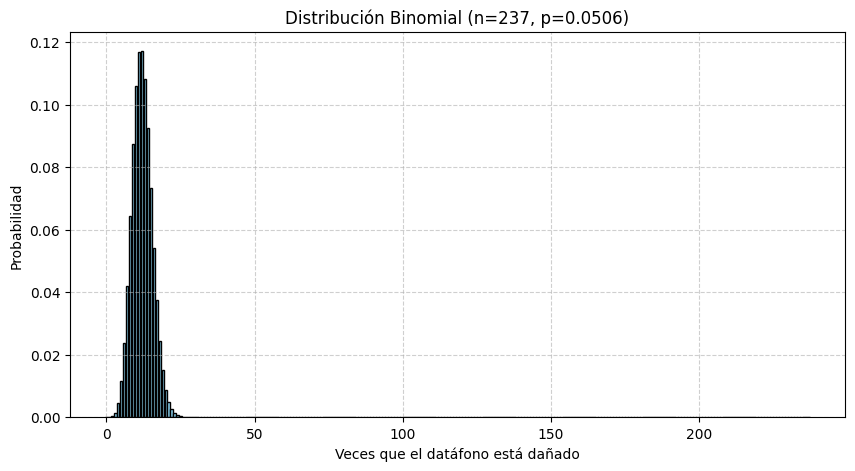

In [59]:
from scipy.stats import binom, chisquare
import matplotlib.pyplot as plt

# Cantidades observadas
n_funcionando = df_tarjeta['tarjetame'].notna().sum()
n_danado = df_tarjeta['tarjetama'].notna().sum()
n_total = n_funcionando + n_danado

# Probabilidad estimada de que esté dañado
p_danado = n_danado / n_total

# Observado y esperado
observed = [n_funcionando, n_danado]
expected = [n_total * (1 - p_danado), n_total * p_danado]

# Prueba de bondad de ajuste (chi-cuadrado)
chi2_stat, p_value = chisquare(f_obs=observed, f_exp=expected)

print("== Prueba de Bondad de Ajuste (Chi-cuadrado) ==")
print(f"Estadístico chi2: {chi2_stat:.4f}")
print(f"p-valor: {p_value:.4f}")

if p_value > 0.05:
    print("No se rechaza H0: la distribución binomial es un buen ajuste.")
else:
    print("Se rechaza H0: la distribución binomial NO es un buen ajuste.")

# Gráfica de la distribución binomial
x = range(0, n_total + 1)
pmf = binom.pmf(x, n_total, p_danado)

plt.figure(figsize=(10, 5))
plt.bar(x, pmf, color='skyblue', edgecolor='black')
plt.title(f'Distribución Binomial (n={n_total}, p={round(p_danado,4)})')
plt.xlabel('Veces que el datáfono está dañado')
plt.ylabel('Probabilidad')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

La probabilidad de que el datafono esté funcionando es del 94.94% y de que no funcione es de 5.06%. Para esta se utilizó la binomial con p= 0,0506

In [60]:
# Distribución para saber que categoría se llevan o no
conteo_no_nulos = df_tiempo_productos.notnull().sum().reset_index(name='Cantidad_no_nulos').rename(columns={'index': 'Columna'})
conteo_no_nulos = conteo_no_nulos.drop(index = [5,6])
conteo_no_nulos['Probabilidad'] = (conteo_no_nulos['Cantidad_no_nulos'] / conteo_no_nulos['Cantidad_no_nulos'].sum()).round(4)
conteo_no_nulos['Probabilidad_acumulada'] = conteo_no_nulos['Probabilidad'].cumsum().round(4)
conteo_no_nulos



,Columna,Cantidad_no_nulos,Probabilidad,Probabilidad_acumulada
0,helados,334,0.1471,0.1471
1,copas,100,0.0441,0.1912
2,gofres,24,0.0106,0.2018
3,bebidas,32,0.0141,0.2159
4,crepes,22,0.0097,0.2256
7,z_score_copas,100,0.0441,0.2697
8,es_outlier_copas,378,0.1665,0.4362
9,z_score_gofres,24,0.0106,0.4468
10,es_outlier_gofres,378,0.1665,0.6133
11,z_score_bebidas,32,0.0141,0.6274


== Prueba de Bondad de Ajuste (Chi-cuadrado) para GOFRES ==
Mezcla Lista: 12 | Mezcla a preparar: 12 | Total: 24
Estadístico chi2: 0.0000
p-valor: 1.0000
No se rechaza H0: la distribución binomial es un buen ajuste.


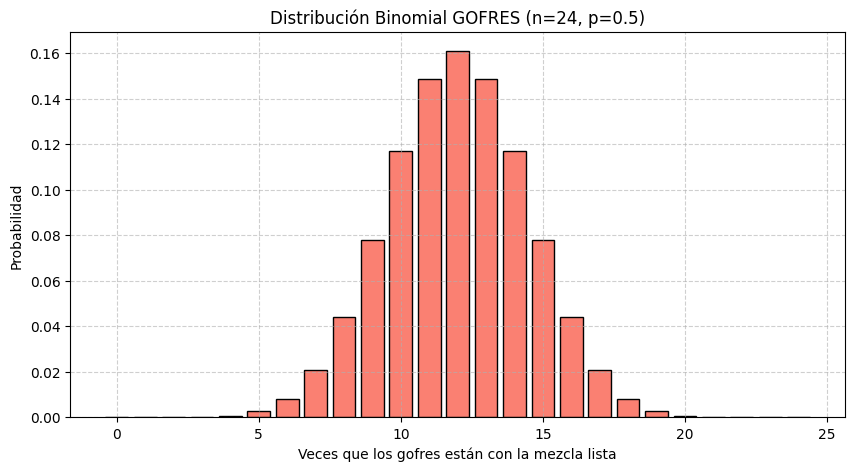

In [61]:
# Distribución para saber si ya hay masa de gofres lista o no
from scipy.stats import binom, chisquare
import matplotlib.pyplot as plt

# Cantidades observadas
n_funcionando = df_tiempo_productos["gofresme"].notna().sum()
n_danado = df_tiempo_productos["gofresma"].notna().sum()
n_total = n_funcionando + n_danado

# Probabilidad estimada de que esté dañado
p_danado = n_danado / n_total

# Observado y esperado
observed = [n_funcionando, n_danado]
expected = [n_total * (1 - p_danado), n_total * p_danado]

# Prueba de bondad de ajuste (chi-cuadrado)
chi2_stat, p_value = chisquare(f_obs=observed, f_exp=expected)

print("== Prueba de Bondad de Ajuste (Chi-cuadrado) para GOFRES ==")
print(f"Mezcla Lista: {n_funcionando} | Mezcla a preparar: {n_danado} | Total: {n_total}")
print(f"Estadístico chi2: {chi2_stat:.4f}")
print(f"p-valor: {p_value:.4f}")

if p_value > 0.05:
    print("No se rechaza H0: la distribución binomial es un buen ajuste.")
else:
    print("Se rechaza H0: la distribución binomial NO es un buen ajuste.")

# Gráfica de la distribución binomial
x = range(0, n_total + 1)
pmf = binom.pmf(x, n_total, p_danado)

plt.figure(figsize=(10, 5))
plt.bar(x, pmf, color='salmon', edgecolor='black')
plt.title(f'Distribución Binomial GOFRES (n={n_total}, p={round(p_danado, 4)})')
plt.xlabel('Veces que los gofres están con la mezcla lista')
plt.ylabel('Probabilidad')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()
 

In [62]:
# Distribuciones para saber cuantos productos 
df_suma_total = df_productos_cant_cal.sum(axis=1).to_frame(name='suma_total')
conteo = df_suma_total.groupby('suma_total').size().reset_index(name='cantidad')

total = df_suma_total.shape[0]
conteo["probabilidad"] = (conteo["cantidad"]/total).round(4)
conteo["probabilidad_acumulada"] = conteo["probabilidad"].cumsum().round(4)
conteo

,suma_total,cantidad,probabilidad,probabilidad_acumulada
0,1,326,0.6221,0.6221
1,2,130,0.2481,0.8702
2,3,38,0.0725,0.9427
3,4,20,0.0382,0.9809
4,5,8,0.0153,0.9962
5,7,2,0.0038,1.0000


Probabilidad de ocupar una mesa si está disponible

In [63]:
# Este código fue realizado con apoyo de ChatGPT (OpenAI, 2025).
df_dia_arribo_mesa = pd.DataFrame()
dias_comunes = set(df_arribo['diaSemana']).intersection(df_mesas['diaSemana'])

for dia in dias_comunes:
    arribo_dia = df_arribo[df_arribo['diaSemana'] == dia][['finPago']].sort_values('finPago').reset_index(drop=True)
    mesa_dia = df_mesas[df_mesas['diaSemana'] == dia][['ocuparMesa', 'liberacionMesa']].sort_values('ocuparMesa').reset_index(drop=True)
    combinado = pd.concat([arribo_dia, mesa_dia], axis=1)
    combinado['diaSemana'] = dia
    combinado = combinado[['diaSemana', 'finPago', 'ocuparMesa', 'liberacionMesa']]
    df_dia_arribo_mesa = pd.concat([df_dia_arribo_mesa, combinado], ignore_index=True)

In [64]:
def prob_mesa(num_mesas=5):
    dias = {}
    for dia in df_dia_arribo_mesa['diaSemana'].unique():
        datos = {'ocupa':[],'libera':[],'disponibles':[],'horas_inicio':[],'horas_fin':[]}
        mesas_disp = num_mesas if dia != 'viernes' else num_mesas-1
        for i in range(len(df_dia_arribo_mesa.query('diaSemana==@dia')['finPago'])):
            if i > 0:
                t_min = df_dia_arribo_mesa.query('diaSemana==@dia').iloc[i-1,1]
                t_max = df_dia_arribo_mesa.query('diaSemana==@dia').iloc[i,1]
                ocp_mesa = df_dia_arribo_mesa.query('diaSemana==@dia').query('ocuparMesa>=@t_min & ocuparMesa<=@t_max')['ocuparMesa']
                lib_mesa = df_dia_arribo_mesa.query('diaSemana==@dia').query('liberacionMesa>=@t_min & liberacionMesa<=@t_max')['liberacionMesa']
                ocp = 0
                lib = 0
                datos['horas_inicio'].append(t_min)
                datos['horas_fin'].append(t_max)
                if not ocp_mesa.empty:
                    mesas_disp -= len(ocp_mesa)
                    ocp += len(ocp_mesa)    
                if not lib_mesa.empty:
                    mesas_disp += len(lib_mesa)
                    lib = len(lib_mesa)
                datos['disponibles'].append(mesas_disp)
                datos['ocupa'].append(ocp)
                datos['libera'].append(lib)
        dias[dia] = datos
    return dias
    
dias = prob_mesa()
df_todos_dias = pd.concat(
    [pd.DataFrame(v).assign(diaSemana=k) for k, v in dias.items()],
    ignore_index=True
)

In [65]:
# Este código fue realizado con apoyo de ChatGPT (OpenAI, 2025).
# --- Función para calcular la probabilidad por grupo ---
def calcular_probabilidad(grupo):
    disponibles = grupo[(grupo['disponibles'].shift(1) > 0)]
    ocupan = disponibles[(disponibles['ocupa'] > 0)]
    if len(disponibles) == 0:
        return np.nan
    return len(ocupan) / len(disponibles)

# --- Calcular probabilidad por día ---
probabilidades_por_dia = df_todos_dias.groupby('diaSemana').apply(calcular_probabilidad).reset_index(name='prob_ocupar_si_disponible')
probabilidades_por_dia

,diaSemana,prob_ocupar_si_disponible
0,domingo,0.203125
1,sábado,0.159091
2,sábado 1,0.091603
3,viernes,0.019608


In [66]:
# Este código fue realizado con apoyo de ChatGPT (OpenAI, 2025).
# --- Extraer todos los días únicos del DataFrame ---
dias_unicos = df_todos_dias['diaSemana'].unique()

# --- Comparar todos los pares de días ---
resultados = []

for dia1, dia2 in combinations(dias_unicos, 2):
    grupo1 = df_todos_dias[df_todos_dias['diaSemana'] == dia1]
    grupo2 = df_todos_dias[df_todos_dias['diaSemana'] == dia2]

    disponibles1 = grupo1[grupo1['disponibles'].shift(1) > 0]
    disponibles2 = grupo2[grupo2['disponibles'].shift(1) > 0]

    ocupan1 = disponibles1[disponibles1['ocupa'] > 0]
    ocupan2 = disponibles2[disponibles2['ocupa'] > 0]

    count = np.array([len(ocupan1), len(ocupan2)])
    nobs = np.array([len(disponibles1), len(disponibles2)])

    if nobs[0] == 0 or nobs[1] == 0:
        continue  # Evita divisiones por cero si no hay datos

    stat, pval = proportions_ztest(count, nobs)

    resultados.append({
        'dia1': dia1,
        'dia2': dia2,
        'proporcion1': count[0] / nobs[0],
        'proporcion2': count[1] / nobs[1],
        'z_stat': stat,
        'p_valor': pval,
        'significativo_0.05': pval < 0.05
    })

# --- Mostrar resultados como DataFrame ---
df_resultados = pd.DataFrame(resultados)
print("\nResultados de comparación de proporciones entre días:")
df_resultados


Resultados de comparación de proporciones entre días:


,dia1,dia2,proporcion1,proporcion2,z_stat,p_valor,significativo_0.05
0,viernes,sábado,0.019608,0.159091,-2.554458,0.010635,True
1,viernes,sábado 1,0.019608,0.091603,-1.693733,0.090316,False
2,viernes,domingo,0.019608,0.203125,-3.096632,0.001957,True
3,sábado,sábado 1,0.159091,0.091603,1.513768,0.130085,False
4,sábado,domingo,0.159091,0.203125,-0.818608,0.413010,False
5,sábado 1,domingo,0.091603,0.203125,-2.536080,0.011210,True


In [67]:
# Este código fue realizado con apoyo de ChatGPT (OpenAI, 2025).

# Crear columna de grupo
df_todos_dias['grupo_dia'] = df_todos_dias['diaSemana'].apply(lambda x: 'viernes' if x == 'viernes' else 'fin de semana')

# Función para calcular la proporción
def calcular_probabilidad(grupo):
    disponibles = grupo[grupo['disponibles'].shift(1) > 0]
    ocupan = disponibles[disponibles['ocupa'] > 0]
    if len(disponibles) == 0:
        return np.nan
    return len(ocupan) / len(disponibles)

# Agrupar por grupo y aplicar
proporcion_por_grupo = df_todos_dias.groupby('grupo_dia').apply(calcular_probabilidad).reset_index(name='ocupar_si_disponible')

# Mostrar resultado
proporcion_por_grupo


,grupo_dia,ocupar_si_disponible
0,fin de semana,0.148997
1,viernes,0.019608


# Validación de distribuciones

In [68]:
pd.DataFrame(df_tiempo_arribos['tiempo_pedido']).to_csv('Archivos TXT/tiempo_pedido.txt', sep='\t', index=False, header=False)
pd.DataFrame(df_friday['tiempo_entre_arribo']).to_csv('Archivos TXT/tiempo_entre_arribo_friday.txt', sep='\t', index=False, header=False)
pd.DataFrame(df_weekend['tiempo_entre_arribo']).to_csv('Archivos TXT/tiempo_entre_arribo_weekend.txt', sep='\t', index=False, header=False)
pd.DataFrame(df_tiempo_productos['helados']).to_csv('Archivos TXT/helados.txt', sep='\t', index=False, header=False)
pd.DataFrame(df_tiempo_productos['copas']).to_csv('Archivos TXT/copas.txt', sep='\t', index=False, header=False)
pd.DataFrame(df_tiempo_productos['crepes']).to_csv('Archivos TXT/crepes.txt', sep='\t', index=False, header=False)
pd.DataFrame(df_tiempo_productos['gofresme'].dropna()).to_csv('Archivos TXT/gofresme.txt', sep='\t', index=False, header=False)
pd.DataFrame(df_tiempo_productos['gofresma'].dropna()).to_csv('Archivos TXT/gofresma.txt', sep='\t', index=False, header=False)
pd.DataFrame(df_tiempo_productos['bebidas']).to_csv('Archivos TXT/bebidas.txt', sep='\t', index=False, header=False)
pd.DataFrame(df_tiempo_productos['artesano'].dropna()).to_csv('Archivos TXT/artesano.txt', sep='\t', index=False, header=False)
pd.DataFrame(df_tiempo_mesa['tiempo_en_mesa']).to_csv('Archivos TXT/tiempo_en_mesa.txt', sep='\t', index=False, header=False)
pd.DataFrame(df_efectivo['efectivo']).to_csv('Archivos TXT/efectivo.txt', sep='\t', index=False, header=False)
pd.DataFrame(df_tarjeta['tarjetame']).to_csv('Archivos TXT/tarjetame.txt', sep='\t', index=False, header=False)
pd.DataFrame(df_tarjeta['tarjetama']).to_csv('Archivos TXT/tarjetama.txt', sep='\t', index=False, header=False)
pd.DataFrame(df_bono['bono']).to_csv('Archivos TXT/bono.txt', sep='\t', index=False, header=False)

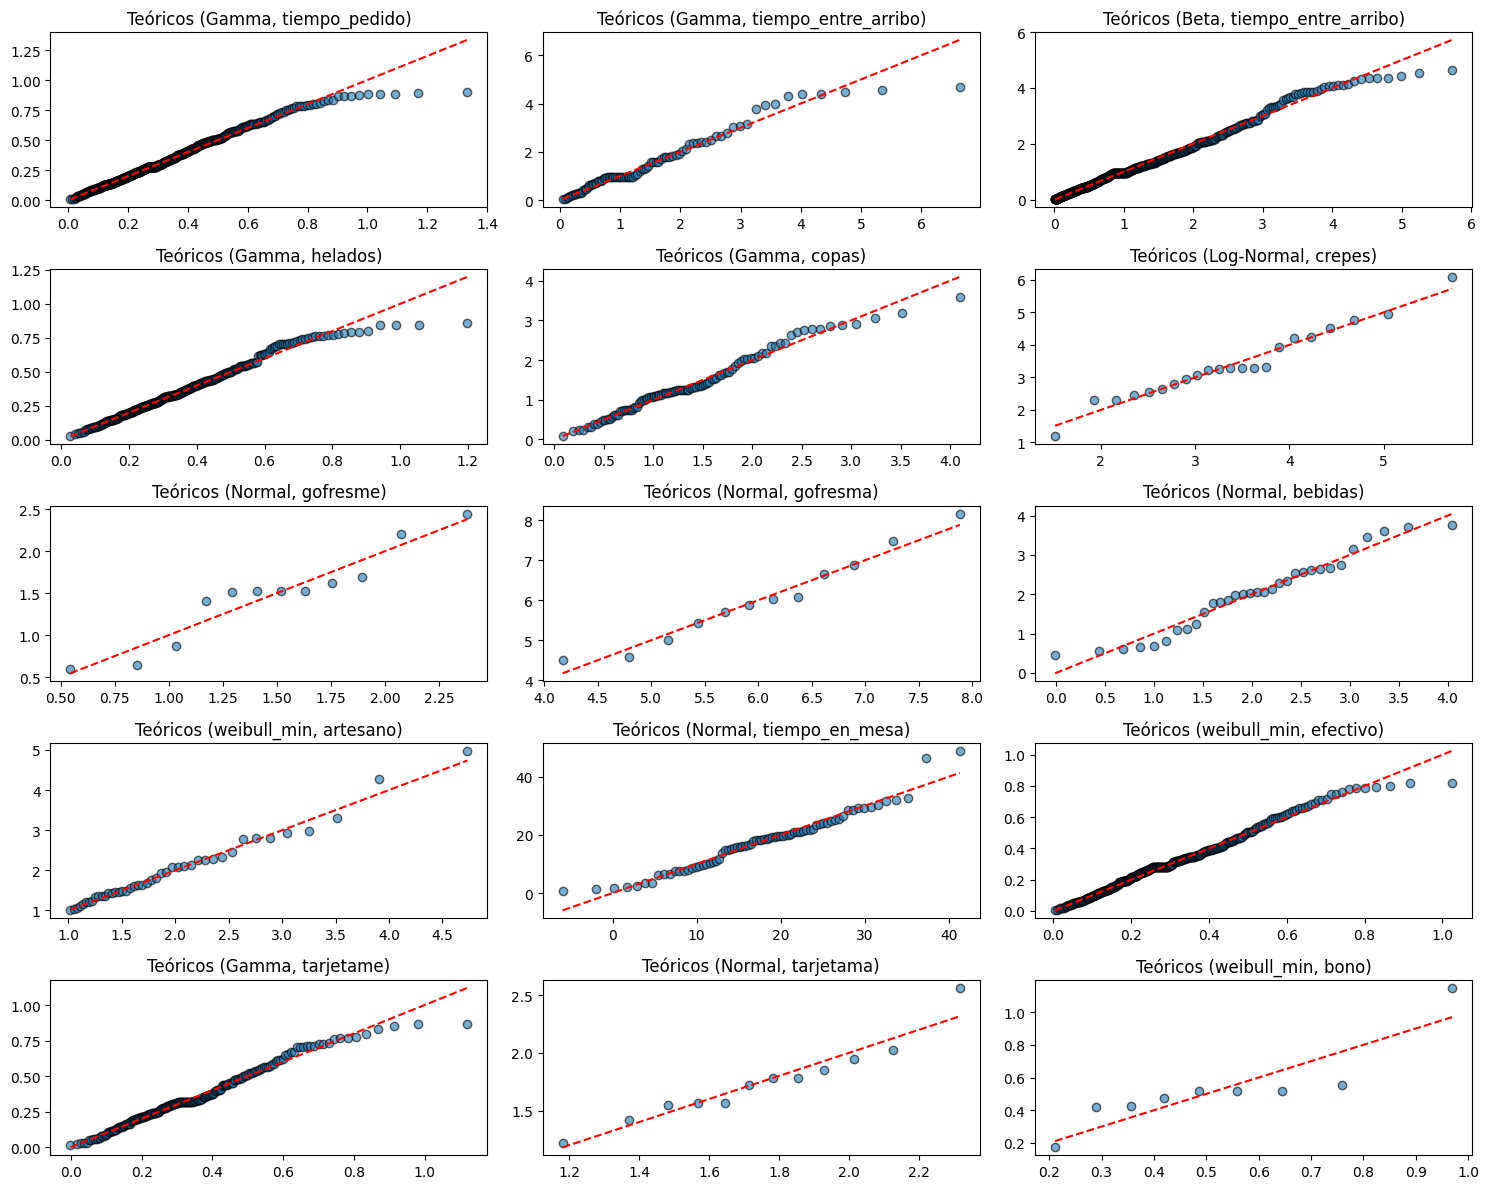

In [69]:
# Este código fue realizado con apoyo de ChatGPT (OpenAI, 2025).
def qq_plot_scipy_ax(data, dist_obj, ax, dist_name=''):
    sorted_data = np.sort(data)
    n = len(sorted_data)
    probs = (np.arange(1, n + 1) - 0.5) / n
    params = dist_obj.fit(data)
    theoretical_quants = dist_obj.ppf(probs, *params)
    ax.scatter(theoretical_quants, sorted_data, edgecolor='k', alpha=0.6)
    ax.plot(theoretical_quants, theoretical_quants, 'r--', label='45° Line')
    ax.set_title(f'Teóricos ({dist_name}, {data.name})')

fig, axes = plt.subplots(5, 3, figsize=(15, 12))
axes = axes.flatten()

datasets = [
    (df_tiempo_arribos['tiempo_pedido'].dropna(), gamma, 'Gamma'),
    (df_friday['tiempo_entre_arribo'].dropna(), gamma, 'Gamma'),
    (df_weekend['tiempo_entre_arribo'].dropna(), beta, 'Beta'),
    (df_tiempo_productos['helados'].dropna(), gamma, 'Gamma'),
    (df_tiempo_productos['copas'].dropna(), gamma, 'Gamma'),
    (df_tiempo_productos['crepes'].dropna(), lognorm, 'Log-Normal'),
    (df_tiempo_productos['gofresme'].dropna(), norm, 'Normal'),
    (df_tiempo_productos['gofresma'].dropna(), norm, 'Normal'),
    (df_tiempo_productos['bebidas'].dropna(), norm, 'Normal'),
    (df_tiempo_productos['artesano'].dropna(), weibull_min, 'weibull_min'),
    (df_tiempo_mesa['tiempo_en_mesa'].dropna(), norm, 'Normal'),
    (df_efectivo['efectivo'].dropna(), weibull_min, 'weibull_min'),
    (df_tarjeta['tarjetame'].dropna(), gamma, 'Gamma'),
    (df_tarjeta['tarjetama'].dropna(), norm, 'Normal'),
    (df_bono['bono'].dropna(), weibull_min, 'weibull_min'),

]

for i, (data, dist, name) in enumerate(datasets):
    qq_plot_scipy_ax(data, dist, axes[i], name)

plt.tight_layout()
plt.show()


In [70]:
valor = len(df_tiempo_arribos["tiempo_pedido"].dropna())
print("Valores reales")
print(df_tiempo_arribos["tiempo_pedido"].dropna().describe())
print("Valores estadisticos")
import numpy as np
import pandas as pd
from scipy.stats import gamma
import scipy.stats as st

alpha = 2.1689
loc = 0.0006
scale = 0.1453

samples = gamma.rvs(a=alpha, loc=loc, scale=scale, size=valor)


df_sim = pd.DataFrame(samples, columns=["tiempo_pedido"])

# Estadísticas descriptivas
stats = df_sim["tiempo_pedido"].describe(percentiles=[0.25, 0.5, 0.75])

# Intervalo de confianza al 95% para la media
mean = stats["mean"]
std = stats["std"]
n = stats["count"]
conf_int = st.t.interval(0.95, df=n-1, loc=mean, scale=std/np.sqrt(n))

# Mostrar resultados
print(stats)
print(f"\n=== Intervalo de confianza del 95% para la media ===")
print(f"({conf_int[0]:.6f}, {conf_int[1]:.6f})")



Valores reales
count    615.000000
mean       0.308211
std        0.196287
min        0.008600
25%        0.157100
50%        0.275200
75%        0.425550
max        0.901800
Name: tiempo_pedido, dtype: float64
Valores estadisticos
count    615.000000
mean       0.315776
std        0.222055
min        0.008857
25%        0.155520
50%        0.272741
75%        0.415066
max        1.441505
Name: tiempo_pedido, dtype: float64

=== Intervalo de confianza del 95% para la media ===
(0.298192, 0.333360)


In [71]:
from scipy.stats import weibull_min, ttest_1samp

# Parámetros Weibull
c = 1.177
loc = 0.0246
scale = 1.6793

# Datos reales sin NaNs
datos_reales = df_friday["tiempo_entre_arribo"].dropna()
n = len(datos_reales)

# Generar valores simulados para estimar la media teórica
simulados = weibull_min.rvs(c=c, loc=loc, scale=scale, size=100000, random_state=42)
media_teorica = simulados.mean()

# Prueba de hipótesis
stat, p_valor = ttest_1samp(datos_reales, popmean=media_teorica)

# Evaluar resultado
if p_valor < 0.05:
    print("❌ No cumple: la media real es significativamente diferente a la esperada según la distribución Weibull.")
else:
    print("✅ Cumple: no hay evidencia suficiente para rechazar que la media real siga la distribución Weibull.")


✅ Cumple: no hay evidencia suficiente para rechazar que la media real siga la distribución Weibull.


In [72]:
from scipy.stats import gamma, ttest_1samp

# Parámetros Gamma
alpha = 0.8553
loc = 0.013
scale = 1.493

# Datos reales sin NaN
datos_reales = df_weekend["tiempo_entre_arribo"].dropna()
n = len(datos_reales)

# Generar valores simulados para estimar la media teórica
simulados = gamma.rvs(a=alpha, loc=loc, scale=scale, size=100000, random_state=42)
media_teorica = simulados.mean()

# Prueba t de una muestra
stat, p_valor = ttest_1samp(datos_reales, popmean=media_teorica)

# Resultado
if p_valor < 0.05:
    print("❌ No cumple: la media real es significativamente diferente a la esperada según la distribución Gamma.")
else:
    print("✅ Cumple: no hay evidencia suficiente para rechazar que la media real siga la distribución Gamma.")


❌ No cumple: la media real es significativamente diferente a la esperada según la distribución Gamma.


In [73]:
from scipy.stats import gamma, ttest_1samp

# Parámetros Gamma
alpha = 3.4551
loc = -0.0073
scale = 0.1042

# Datos reales (sin NaN)
datos_reales = df_tiempo_productos["helados"].dropna()
n = len(datos_reales)

# Generar valores simulados para estimar media teórica
simulados = gamma.rvs(a=alpha, loc=loc, scale=scale, size=100000, random_state=42)
media_teorica = simulados.mean()

# Prueba de hipótesis (t de una muestra)
stat, p_valor = ttest_1samp(datos_reales, popmean=media_teorica)

# Resultado
if p_valor < 0.05:
    print("❌ No cumple: la media real de 'helados' es significativamente diferente a la esperada según Gamma.")
else:
    print("✅ Cumple: no hay evidencia suficiente para rechazar que la media real siga la distribución Gamma.")


✅ Cumple: no hay evidencia suficiente para rechazar que la media real siga la distribución Gamma.


In [74]:
from scipy.stats import gamma, ttest_1samp

# Parámetros Gamma para 'copas'
alpha = 3.9793
loc = -0.176
scale = 0.3905

# Datos reales sin NaN
datos_reales = df_tiempo_productos["copas"].dropna()
n = len(datos_reales)

# Simulación para estimar media teórica
simulados = gamma.rvs(a=alpha, loc=loc, scale=scale, size=100000, random_state=42)
media_teorica = simulados.mean()

# Prueba de hipótesis
stat, p_valor = ttest_1samp(datos_reales, popmean=media_teorica)

# Resultado
if p_valor < 0.05:
    print("❌ No cumple: la media real de 'copas' es significativamente diferente a la esperada según Gamma.")
else:
    print("✅ Cumple: no hay evidencia suficiente para rechazar que la media real siga la distribución Gamma.")


✅ Cumple: no hay evidencia suficiente para rechazar que la media real siga la distribución Gamma.


In [75]:
from scipy.stats import norm, ttest_1samp

# Parámetros de la distribución normal
mu = 1.463
std = 0.5306

# Datos reales
datos_reales = df_tiempo_productos["gofresme"].dropna()
n = len(datos_reales)

# Prueba de hipótesis
stat, p_valor = ttest_1samp(datos_reales, popmean=mu)

# Resultado
if p_valor < 0.05:
    print("❌ No cumple: la media real de 'gofresme' es significativamente diferente a la esperada según Normal.")
else:
    print("✅ Cumple: no hay evidencia suficiente para rechazar que la media real siga la distribución Normal.")


✅ Cumple: no hay evidencia suficiente para rechazar que la media real siga la distribución Normal.


In [76]:
from scipy.stats import norm, ttest_1samp

# Parámetros de la distribución normal
mu = 6.029
std = 1.0715

# Datos reales
datos_reales = df_tiempo_productos["gofresma"].dropna()
n = len(datos_reales)

# Prueba de hipótesis
stat, p_valor = ttest_1samp(datos_reales, popmean=mu)

# Resultado
if p_valor < 0.05:
    print("❌ No cumple: la media real de 'gofresma' es significativamente diferente a la esperada según Normal.")
else:
    print("✅ Cumple: no hay evidencia suficiente para rechazar que la media real siga la distribución Normal.")


✅ Cumple: no hay evidencia suficiente para rechazar que la media real siga la distribución Normal.


In [77]:
from scipy.stats import norm, ttest_1samp

# Parámetros de la distribución normal
mu = 2.0191
std = 0.9414

# Datos reales
datos_reales = df_tiempo_productos["bebidas"].dropna()
n = len(datos_reales)

# Prueba de hipótesis
stat, p_valor = ttest_1samp(datos_reales, popmean=mu)

# Resultado
if p_valor < 0.05:
    print("❌ No cumple: la media real de 'bebidas' es significativamente diferente a la esperada según Normal.")
else:
    print("✅ Cumple: no hay evidencia suficiente para rechazar que la media real siga la distribución Normal.")


✅ Cumple: no hay evidencia suficiente para rechazar que la media real siga la distribución Normal.


In [78]:
from scipy.stats import lognorm, ttest_1samp
import numpy as np

# Parámetros de la distribución lognormal
s = 0.3344
loc = 0.0
scale = 3.2182

# Datos reales
datos_reales = df_tiempo_productos["crepes"].dropna()
n = len(datos_reales)

# Generar muestras para estimar la media teórica
simulados = lognorm.rvs(s=s, loc=loc, scale=scale, size=100000, random_state=42)
media_teorica = simulados.mean()

# Prueba de hipótesis
stat, p_valor = ttest_1samp(datos_reales, popmean=media_teorica)

# Resultado
if p_valor < 0.05:
    print("❌ No cumple: la media real de 'crepes' es significativamente diferente a la esperada según Lognormal.")
else:
    print("✅ Cumple: no hay evidencia suficiente para rechazar que la media real siga la distribución Lognormal.")


✅ Cumple: no hay evidencia suficiente para rechazar que la media real siga la distribución Lognormal.


In [79]:
from scipy.stats import weibull_min, ttest_1samp

# Parámetros de la distribución Weibull
c = 1.1254
loc = 0.9999
scale = 0.9858

# Datos reales
datos_reales = df_tiempo_productos["artesano"].dropna()
n = len(datos_reales)

# Simulación para estimar la media teórica
simulados = weibull_min.rvs(c=c, loc=loc, scale=scale, size=100000, random_state=42)
media_teorica = simulados.mean()

# Prueba de hipótesis
stat, p_valor = ttest_1samp(datos_reales, popmean=media_teorica)

# Resultado
if p_valor < 0.05:
    print("❌ No cumple: la media real de 'artesano' es significativamente diferente a la esperada según Weibull.")
else:
    print("✅ Cumple: no hay evidencia suficiente para rechazar que la media real siga la distribución Weibull.")


✅ Cumple: no hay evidencia suficiente para rechazar que la media real siga la distribución Weibull.


In [80]:
from scipy.stats import norm, ttest_1samp

# Parámetros de la distribución normal
mu = 17.9058
std = 9.4197

# Datos reales
datos_reales = df_tiempo_mesa["tiempo_en_mesa"].dropna()
n = len(datos_reales)

# Prueba de hipótesis
stat, p_valor = ttest_1samp(datos_reales, popmean=mu)

# Resultado
if p_valor < 0.05:
    print("❌ No cumple: la media real de 'tiempo_en_mesa' es significativamente diferente a la esperada según Normal.")
else:
    print("✅ Cumple: no hay evidencia suficiente para rechazar que la media real siga la distribución Normal.")


✅ Cumple: no hay evidencia suficiente para rechazar que la media real siga la distribución Normal.


In [81]:
from scipy.stats import weibull_min, ttest_1samp

c = 1.6373
loc = -0.0014
scale = 0.3241

# Datos reales
datos_reales = df_efectivo.iloc[:, 0].dropna()
n = len(datos_reales)

# Simulación para estimar la media teórica
simulados = weibull_min.rvs(c=c, loc=loc, scale=scale, size=100000, random_state=42)
media_teorica = simulados.mean()

# Prueba de hipótesis
stat, p_valor = ttest_1samp(datos_reales, popmean=media_teorica)

# Resultado
if p_valor < 0.05:
    print("❌ No cumple: la media real de 'efectivo' es significativamente diferente a la esperada según Weibull.")
else:
    print("✅ Cumple: no hay evidencia suficiente para rechazar que la media real siga la distribución Weibull.")

✅ Cumple: no hay evidencia suficiente para rechazar que la media real siga la distribución Weibull.


In [82]:
from scipy.stats import gamma, ttest_1samp

# Parámetros de la distribución Gamma
alpha = 4.0366
loc = -0.0549
scale = 0.0972

# Datos reales
datos_reales = df_tarjeta["tarjetame"].dropna()
n = len(datos_reales)

# Simulación para estimar la media teórica
simulados = gamma.rvs(a=alpha, loc=loc, scale=scale, size=100000, random_state=42)
media_teorica = simulados.mean()

# Prueba de hipótesis
stat, p_valor = ttest_1samp(datos_reales, popmean=media_teorica)

# Resultado
if p_valor < 0.05:
    print("❌ No cumple: la media real de 'tarjetame' es significativamente diferente a la esperada según Gamma.")
else:
    print("✅ Cumple: no hay evidencia suficiente para rechazar que la media real siga la distribución Gamma.")


✅ Cumple: no hay evidencia suficiente para rechazar que la media real siga la distribución Gamma.


In [83]:
from scipy.stats import norm, ttest_1samp

# Parámetros de la distribución normal
mu = 1.7491
std = 0.328

# Datos reales
datos_reales = df_tarjeta["tarjetama"].dropna()
n = len(datos_reales)

# Prueba de hipótesis
stat, p_valor = ttest_1samp(datos_reales, popmean=mu)

# Resultado
if p_valor < 0.05:
    print("❌ No cumple: la media real de 'tarjetama' es significativamente diferente a la esperada según Normal.")
else:
    print("✅ Cumple: no hay evidencia suficiente para rechazar que la media real siga la distribución Normal.")


✅ Cumple: no hay evidencia suficiente para rechazar que la media real siga la distribución Normal.


In [84]:
from scipy.stats import weibull_min, ttest_1samp

# Parámetros de la distribución Weibull
c = 1.649
loc = 0.1338
scale = 0.4391

# Datos reales
datos_reales = df_bono.iloc[:, 0].dropna()
n = len(datos_reales)

# Simulación para estimar la media teórica
simulados = weibull_min.rvs(c=c, loc=loc, scale=scale, size=100000, random_state=42)
media_teorica = simulados.mean()

# Prueba de hipótesis
stat, p_valor = ttest_1samp(datos_reales, popmean=media_teorica)

# Resultado
if p_valor < 0.05:
    print("❌ No cumple: la media real de 'bono' es significativamente diferente a la esperada según Weibull.")
else:
    print("✅ Cumple: no hay evidencia suficiente para rechazar que la media real siga la distribución Weibull.")


✅ Cumple: no hay evidencia suficiente para rechazar que la media real siga la distribución Weibull.


# productos

In [103]:
import pandas as pd
import ast

# Lista de columnas de productos (tipo de productos)
columnas_productos = ['bebidas', 'crepes', 'copas', 'helados', 'gofres']

# Paso 1: Crear una copia del DataFrame original para trabajar sin modificarlo
df_temp = df_productos.copy()

# Paso 2: Convertir cadenas de texto que parecen listas en listas reales en el DataFrame temporal
for col in columnas_productos:
    df_temp[col] = df_temp[col].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Paso 3: Detectar si el helado es artesanal en la columna "observacion"
df_temp['artesano'] = df_temp['observacion'].apply(
    lambda x: 'artesano' in x.lower() if isinstance(x, str) else False
)

# Paso 4: Trasladar los helados artesanales a la columna 'artesano' y dejar vacíos en la columna de helados
df_temp['helados'] = df_temp.apply(
    lambda row: [] if row['artesano'] else row['helados'], axis=1
)

# Paso 5: Contamos la frecuencia de aparición de cada tipo de producto (sin modificar el DataFrame original)
frecuencias_productos = {col: df_temp[col].apply(lambda x: len(x) > 0).sum() for col in columnas_productos}

# Paso 6: Contamos la frecuencia de helado artesanal (en la nueva columna 'artesano')
frecuencia_artesano = df_temp['artesano'].sum()

# Paso 7: Calculamos la probabilidad de que se elija cada tipo de producto
total_pedidos = sum(frecuencias_productos.values())  # Total de productos en los pedidos
probabilidades = {producto: frecuencia / total_pedidos for producto, frecuencia in frecuencias_productos.items()}

# Probabilidad de helado artesanal (ya está considerada en 'artesano', no en helados)
probabilidades['artesano'] = frecuencia_artesano / total_pedidos

# Paso 8: Crear el DataFrame para la distribución discreta
df_distribucion = pd.DataFrame(list(probabilidades.items()), columns=['producto', 'probabilidad'])

# Paso 9: Calcular la probabilidad acumulada
df_distribucion['prob_acumulada'] = df_distribucion['probabilidad'].cumsum()

# Paso 10: Mostrar la distribución con la probabilidad acumulada
print("Distribución discreta con probabilidad acumulada (incluyendo helado artesanal):")
print(df_distribucion)


Distribución discreta con probabilidad acumulada (incluyendo helado artesanal):
   producto  probabilidad  prob_acumulada
0   bebidas      0.060952        0.060952
1    crepes      0.041905        0.102857
2     copas      0.190476        0.293333
3   helados      0.660952        0.954286
4    gofres      0.045714        1.000000
5  artesano      0.060952        1.060952


In [91]:
df_prod = df_productos[['bebidas', 'crepes', 'copas', 'helados', 'gofres','observacion']]
df_prod['artesano'] = df_prod['observacion'][]

,bebidas,crepes,copas,helados,gofres,observacion
0,[],[],[],"[{'inicio': '14:27:09,739', 'fin': '14:27:40,0...",[],NaN
1,[],[],[],"[{'inicio': '13:23:46,397', 'fin': '13:24:18,5...",[],NaN
2,[],[],[],"[{'inicio': '13:41:12,604', 'fin': '13:41:26,0...",[],NaN
3,[],[],[],"[{'inicio': '13:58:57,860', 'fin': '13:59:21,3...",[],NaN
4,"[{'inicio': '13:10:53,426', 'fin': '13:12:45,2...",[],[],[],[],!Fueron dos malteadas
...,...,...,...,...,...,...
519,[],[],[],"[{'inicio': '14:20:05,375', 'fin': '14:20:24,9...",[],NaN
520,[],[],[],"[{'inicio': '14:30:12,471', 'fin': '14:30:31,8...",[],NaN
521,[],[],[],"[{'inicio': '13:24:50,635', 'fin': '13:25:23,3...",[],NaN
522,[],[],[],"[{'inicio': '15:00:18,570', 'fin': '15:01:21,7...",[],NaN
